# Climate Indices analysis  for subseaonal forecast - Part II

#### Experiment design:
1. Input variables (X):
   - Surface meterlogy, Surface water temperature, Ice cover (from previous days), climate indices- 1995 onwards
    
2. Output variables (y):
   - Ice data (1995 onwards)
    
3. Period: 
   - 1996 to 2021 (25 years). Note that 1996 includes winter of 1995/1996
   - Training(60%) - 1996 to 2010
   - Validation(20%) - 2011 to 2015
   - Test(20%) - 2016 to 2021
    
4. Predict Interval:
   - Short term foreacast: 5 days and 7 days
   - Subseasonal forecast: 5 weeks (35 days) 
    
5. Preperation of input data:
   - Surface meteorology: daily frequency data - 7 day(168 hours) history data/lag
   - Ice data: daily frequency - 7 day history/lag
   - Water Surface temperature: daily - 7 day history/lag
   - Climate indices: monthly - 3 month history/lag + daily - 7 day lag
   
            Example : If today is 1st Nov at 12 EST then inputs will be...
                  - Surface met: 25th Oct 6 EST to 1st Nov 6 EST
                  - Ice data: 25th Oct to 31st Oct
                  - Water surface temperature: 25th Oct to 31st Oct
                  - Climate indices: July,Aug,Sep
    - Note that the lag periods(7 days/3 months) can be tested in the Hyperparameter tuning phase

### 1. Preperation of Input data

In [ ]:
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline   
pd.plotting.register_matplotlib_converters()           
import seaborn as sns  
import altair as alt
from vega_datasets import data
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
meteorology = pd.read_excel("/content/drive/MyDrive/MIDAS-Code+data/Data/meteorlogy_daily.xlsx")
surface_temp = pd.read_csv("/content/drive/MyDrive/MIDAS-Code+data/Data/Surface_Temperature_Without_Remove.csv", usecols=['Date', 'Sup.', 'Huron'], 
                           dtype= {'Sup.':float, 'Huron':float})
ice_data = pd.read_excel("/content/drive/MyDrive/MIDAS-Code+data/Data/ice_data_without_remove.xlsx")
climate_ind_m = pd.read_csv("/content/drive/MyDrive/MIDAS-Code+data/Data/climate_ind_daily.csv")

In [ ]:
meteorology.head()

date    u-wind    v-wind   pressure  humidity  temperature
0 1995-01-01  2.381250 -0.628125  98903.125    30.375   270.178146
1 1995-01-02  4.033125 -1.283125  98336.875    25.500   267.714500
2 1995-01-03  5.938750  0.482500  98652.500    17.125   265.636627
3 1995-01-04  3.722500 -1.425625  99073.125     7.375   259.524513
4 1995-01-05  7.392500  2.583125  98769.375    16.625   264.535141

In [ ]:
meteorology.dtypes

date           datetime64[ns]
u-wind                float64
v-wind                float64
pressure              float64
humidity              float64
temperature           float64
dtype: object

In [ ]:
meteorology = meteorology.set_index('date')
meteorology.head()

u-wind    v-wind   pressure  humidity  temperature
date                                                            
1995-01-01  2.381250 -0.628125  98903.125    30.375   270.178146
1995-01-02  4.033125 -1.283125  98336.875    25.500   267.714500
1995-01-03  5.938750  0.482500  98652.500    17.125   265.636627
1995-01-04  3.722500 -1.425625  99073.125     7.375   259.524513
1995-01-05  7.392500  2.583125  98769.375    16.625   264.535141

In [ ]:
look_back = 4 ############## This will create only 3 lags for all features since the training data contains only 5844 records.

In [ ]:
lags = range(1, look_back)

meteorology = meteorology.assign(**{
    f'{col}{lag}': meteorology[col].shift(lag)
    for lag in lags
    for col in meteorology
})

meteorology.head(10)

u-wind    v-wind    pressure  ...  pressure3  humidity3  temperature3
date                                        ...                                    
1995-01-01  2.381250 -0.628125   98903.125  ...        NaN        NaN           NaN
1995-01-02  4.033125 -1.283125   98336.875  ...        NaN        NaN           NaN
1995-01-03  5.938750  0.482500   98652.500  ...        NaN        NaN           NaN
1995-01-04  3.722500 -1.425625   99073.125  ...  98903.125     30.375    270.178146
1995-01-05  7.392500  2.583125   98769.375  ...  98336.875     25.500    267.714500
1995-01-06  5.763750  2.210625   97803.125  ...  98652.500     17.125    265.636627
1995-01-07  0.098125 -3.118125   98220.000  ...  99073.125      7.375    259.524513
1995-01-08  3.726875  2.000625   98293.750  ...  98769.375     16.625    264.535141
1995-01-09  4.055000 -0.819375   99311.875  ...  97803.125     36.500    269.011017
1995-01-10 -2.220625 -1.595000  100214.375  ...  98220.000      8.000    262.210144

[10 rows x 20 columns]

In [ ]:
surface_temp.head()

Date  Sup.  Huron
0  1995/1/1 0:00  3.29   4.50
1  1995/1/2 0:00  3.28   4.45
2  1995/1/3 0:00  3.27   4.39
3  1995/1/4 0:00  3.27   4.33
4  1995/1/5 0:00  3.22   4.18

In [ ]:
surface_temp.dtypes

Date      object
Sup.     float64
Huron    float64
dtype: object

In [ ]:
surface_temp['Date'] = pd.to_datetime(surface_temp['Date'], errors = 'coerce')
surface_temp.head()

Date  Sup.  Huron
0 1995-01-01  3.29   4.50
1 1995-01-02  3.28   4.45
2 1995-01-03  3.27   4.39
3 1995-01-04  3.27   4.33
4 1995-01-05  3.22   4.18

In [ ]:
surface_temp = surface_temp.set_index('Date')
surface_temp.head()

Sup.  Huron
Date                   
1995-01-01  3.29   4.50
1995-01-02  3.28   4.45
1995-01-03  3.27   4.39
1995-01-04  3.27   4.33
1995-01-05  3.22   4.18

In [ ]:
lags = range(1, look_back)

surface_temp = surface_temp.assign(**{
    f'{col}{lag}': surface_temp[col].shift(lag)
    for lag in lags
    for col in surface_temp
})

surface_temp.head(10)

Sup.  Huron  Sup.1  Huron1  Sup.2  Huron2  Sup.3  Huron3
Date                                                                
1995-01-01  3.29   4.50    NaN     NaN    NaN     NaN    NaN     NaN
1995-01-02  3.28   4.45   3.29    4.50    NaN     NaN    NaN     NaN
1995-01-03  3.27   4.39   3.28    4.45   3.29    4.50    NaN     NaN
1995-01-04  3.27   4.33   3.27    4.39   3.28    4.45   3.29    4.50
1995-01-05  3.22   4.18   3.27    4.33   3.27    4.39   3.28    4.45
1995-01-06  3.19   4.06   3.22    4.18   3.27    4.33   3.27    4.39
1995-01-07  3.14   3.90   3.19    4.06   3.22    4.18   3.27    4.33
1995-01-08  3.10   3.75   3.14    3.90   3.19    4.06   3.22    4.18
1995-01-09  3.02   3.59   3.10    3.75   3.14    3.90   3.19    4.06
1995-01-10  2.95   3.25   3.02    3.59   3.10    3.75   3.14    3.90

In [ ]:
climate_ind_m.head()

dateTime   NAO   PNA  EPNP  SOI
0  1995-01-01  0.93  0.66  1.03 -0.4
1  1995-01-02  0.93  0.66  1.03 -0.4
2  1995-01-03  0.93  0.66  1.03 -0.4
3  1995-01-04  0.93  0.66  1.03 -0.4
4  1995-01-05  0.93  0.66  1.03 -0.4

In [ ]:
climate_ind_m.dtypes

dateTime     object
NAO         float64
PNA         float64
EPNP        float64
SOI         float64
dtype: object

Observation - Climate indices data is of monthly frequency whereas the rest of the indices are of daily frequency. Hence, we need to convert the Climate indices data to daily frequency inorder to create the consolidated input file.

In [ ]:
#Inorder to Upsample the Climate indices data, the dateTime feature has to be an index and has to be a datetime object. 
climate_ind_m['dateTime'] = pd.to_datetime(climate_ind_m['dateTime'], errors='coerce')
climate_ind_m.set_index('dateTime', inplace=True)
climate_ind_m.head()

NAO   PNA  EPNP  SOI
dateTime                         
1995-01-01  0.93  0.66  1.03 -0.4
1995-01-02  0.93  0.66  1.03 -0.4
1995-01-03  0.93  0.66  1.03 -0.4
1995-01-04  0.93  0.66  1.03 -0.4
1995-01-05  0.93  0.66  1.03 -0.4

In [ ]:
#Resample at daily frequnecy, use the start value(in a month) to forward fill for the rest of the days in the month
climate_ind_d = climate_ind_m.resample('D', convention='start').ffill()
climate_ind_d.value_counts()

NAO    PNA    EPNP   SOI 
 0.01  -2.20  -0.57  -0.3    31
-0.29  -0.48   0.63   0.7    31
-0.12  -0.02   0.26   1.0    31
-0.14   1.98  -0.67   0.4    31
-0.19   0.65  -1.39  -0.2    31
                             ..
-0.06   0.14  -0.29  -3.1    28
 1.14   0.73   0.05  -0.1    28
-0.11   0.89  -0.33  -2.0    28
-0.51  -0.11   0.57   0.1    28
 0.00   0.06  -1.28   1.4     1
Length: 319, dtype: int64

Observation - The climate indices been converted to daily level

In [ ]:
#climate_ind_d.reset_index(inplace=True)
climate_ind_d.head()

NAO   PNA  EPNP  SOI
dateTime                         
1995-01-01  0.93  0.66  1.03 -0.4
1995-01-02  0.93  0.66  1.03 -0.4
1995-01-03  0.93  0.66  1.03 -0.4
1995-01-04  0.93  0.66  1.03 -0.4
1995-01-05  0.93  0.66  1.03 -0.4

In [ ]:
lags = range(1, look_back)

climate_ind_d = climate_ind_d.assign(**{
    f'{col}{lag}': climate_ind_d[col].shift(lag)
    for lag in lags
    for col in climate_ind_d
})

climate_ind_d.head(10)

NAO   PNA  EPNP  SOI  NAO1  ...  SOI2  NAO3  PNA3  EPNP3  SOI3
dateTime                                 ...                               
1995-01-01  0.93  0.66  1.03 -0.4   NaN  ...   NaN   NaN   NaN    NaN   NaN
1995-01-02  0.93  0.66  1.03 -0.4  0.93  ...   NaN   NaN   NaN    NaN   NaN
1995-01-03  0.93  0.66  1.03 -0.4  0.93  ...  -0.4   NaN   NaN    NaN   NaN
1995-01-04  0.93  0.66  1.03 -0.4  0.93  ...  -0.4  0.93  0.66   1.03  -0.4
1995-01-05  0.93  0.66  1.03 -0.4  0.93  ...  -0.4  0.93  0.66   1.03  -0.4
1995-01-06  0.93  0.66  1.03 -0.4  0.93  ...  -0.4  0.93  0.66   1.03  -0.4
1995-01-07  0.93  0.66  1.03 -0.4  0.93  ...  -0.4  0.93  0.66   1.03  -0.4
1995-01-08  0.93  0.66  1.03 -0.4  0.93  ...  -0.4  0.93  0.66   1.03  -0.4
1995-01-09  0.93  0.66  1.03 -0.4  0.93  ...  -0.4  0.93  0.66   1.03  -0.4
1995-01-10  0.93  0.66  1.03 -0.4  0.93  ...  -0.4  0.93  0.66   1.03  -0.4

[10 rows x 16 columns]

#### 1.1. Independent variables

In [ ]:
meteorology = meteorology.reset_index()
meteorology = meteorology.rename(columns={'date': 'Date'})
meteorology.columns

Index(['Date', 'u-wind', 'v-wind', 'pressure', 'humidity', 'temperature',
       'u-wind1', 'v-wind1', 'pressure1', 'humidity1', 'temperature1',
       'u-wind2', 'v-wind2', 'pressure2', 'humidity2', 'temperature2',
       'u-wind3', 'v-wind3', 'pressure3', 'humidity3', 'temperature3'],
      dtype='object')

In [ ]:
surface_temp = surface_temp.reset_index()
surface_temp.columns

Index(['Date', 'Sup.', 'Huron', 'Sup.1', 'Huron1', 'Sup.2', 'Huron2', 'Sup.3',
       'Huron3'],
      dtype='object')

In [ ]:
climate_ind_d = climate_ind_d.reset_index()
climate_ind_d = climate_ind_d.rename(columns={'dateTime': 'Date'})
climate_ind_d.columns

Index(['Date', 'NAO', 'PNA', 'EPNP', 'SOI', 'NAO1', 'PNA1', 'EPNP1', 'SOI1',
       'NAO2', 'PNA2', 'EPNP2', 'SOI2', 'NAO3', 'PNA3', 'EPNP3', 'SOI3'],
      dtype='object')

In [ ]:
df_merge_inter = meteorology.merge(surface_temp, how = 'inner', on = 'Date')
df_merge = df_merge_inter.merge(climate_ind_d, how = 'inner', on = 'Date')
df_merge.shape

(9678, 45)

In [ ]:
df_merge.head(10)

Date    u-wind    v-wind    pressure  ...  NAO3  PNA3  EPNP3  SOI3
0 1995-01-01  2.381250 -0.628125   98903.125  ...   NaN   NaN    NaN   NaN
1 1995-01-02  4.033125 -1.283125   98336.875  ...   NaN   NaN    NaN   NaN
2 1995-01-03  5.938750  0.482500   98652.500  ...   NaN   NaN    NaN   NaN
3 1995-01-04  3.722500 -1.425625   99073.125  ...  0.93  0.66   1.03  -0.4
4 1995-01-05  7.392500  2.583125   98769.375  ...  0.93  0.66   1.03  -0.4
5 1995-01-06  5.763750  2.210625   97803.125  ...  0.93  0.66   1.03  -0.4
6 1995-01-07  0.098125 -3.118125   98220.000  ...  0.93  0.66   1.03  -0.4
7 1995-01-08  3.726875  2.000625   98293.750  ...  0.93  0.66   1.03  -0.4
8 1995-01-09  4.055000 -0.819375   99311.875  ...  0.93  0.66   1.03  -0.4
9 1995-01-10 -2.220625 -1.595000  100214.375  ...  0.93  0.66   1.03  -0.4

[10 rows x 45 columns]

#### 1.2. Target variable

In [ ]:
#ice_data = ice_data.drop(list(range(0,look_back + predict_interval - 2)))
ice_data = ice_data.rename(columns={'date': 'Date'})
ice_data.head()

Date  Ice
0 1995-01-01  0.0
1 1995-01-02  0.0
2 1995-01-03  0.0
3 1995-01-04  0.0
4 1995-01-05  0.0

In [ ]:
ice_data.tail()

Date  Ice
9673 2021-06-26  0.0
9674 2021-06-27  0.0
9675 2021-06-28  0.0
9676 2021-06-29  0.0
9677 2021-06-30  0.0

In [ ]:
ice_data = ice_data.set_index('Date')
lags = range(1, look_back)

ice_data = ice_data.assign(**{
    f'{col}{lag}': ice_data[col].shift(lag)
    for lag in lags
    for col in ice_data
})

ice_data = ice_data.reset_index()
ice_data.head(10)

Date        Ice       Ice1  Ice2  Ice3
0 1995-01-01   0.000000        NaN   NaN   NaN
1 1995-01-02   0.000000   0.000000   NaN   NaN
2 1995-01-03   0.000000   0.000000   0.0   NaN
3 1995-01-04   0.000000   0.000000   0.0   0.0
4 1995-01-05   0.000000   0.000000   0.0   0.0
5 1995-01-06   0.000000   0.000000   0.0   0.0
6 1995-01-07   0.000000   0.000000   0.0   0.0
7 1995-01-08   0.000000   0.000000   0.0   0.0
8 1995-01-09  62.446242   0.000000   0.0   0.0
9 1995-01-10  77.650264  62.446242   0.0   0.0

#### 1.3. Normalization

In [ ]:
# normalize the input data

scaler_train = MinMaxScaler(feature_range=(0,1))
input_columns = df_merge.iloc[:,1:].columns
standard_array = scaler_train.fit_transform(df_merge.iloc[:,1:].values) 
df_norm = pd.DataFrame(standard_array)
df_norm.columns = input_columns

# reset the index for the date dataframe
df_norm = pd.concat([df_merge.iloc[:,0].to_frame().reset_index(drop=True), df_norm], axis = 1)
df_norm.head()

Date    u-wind    v-wind  pressure  ...      NAO3      PNA3     EPNP3  SOI3
0 1995-01-01  0.615115  0.473178  0.516700  ...       NaN       NaN       NaN   NaN
1 1995-01-02  0.711702  0.427545  0.410524  ...       NaN       NaN       NaN   NaN
2 1995-01-03  0.823125  0.550553  0.469706  ...       NaN       NaN       NaN   NaN
3 1995-01-04  0.693539  0.417617  0.548576  ...  0.718531  0.650442  0.608403  0.45
4 1995-01-05  0.908127  0.696900  0.491621  ...  0.718531  0.650442  0.608403  0.45

[5 rows x 45 columns]

In [ ]:
df_data = ice_data.merge(df_norm, on = 'Date', how = 'inner')
df_data = df_data.set_index('Date')
df_data.head(10)

Ice       Ice1  Ice2  ...      PNA3     EPNP3  SOI3
Date                                    ...                          
1995-01-01   0.000000        NaN   NaN  ...       NaN       NaN   NaN
1995-01-02   0.000000   0.000000   NaN  ...       NaN       NaN   NaN
1995-01-03   0.000000   0.000000   0.0  ...       NaN       NaN   NaN
1995-01-04   0.000000   0.000000   0.0  ...  0.650442  0.608403  0.45
1995-01-05   0.000000   0.000000   0.0  ...  0.650442  0.608403  0.45
1995-01-06   0.000000   0.000000   0.0  ...  0.650442  0.608403  0.45
1995-01-07   0.000000   0.000000   0.0  ...  0.650442  0.608403  0.45
1995-01-08   0.000000   0.000000   0.0  ...  0.650442  0.608403  0.45
1995-01-09  62.446242   0.000000   0.0  ...  0.650442  0.608403  0.45
1995-01-10  77.650264  62.446242   0.0  ...  0.650442  0.608403  0.45

[10 rows x 48 columns]

In [ ]:
df_data.tail(10)

Ice  Ice1  Ice2  Ice3  ...      NAO3      PNA3     EPNP3      SOI3
Date                               ...                                        
2021-06-21  0.0   0.0   0.0   0.0  ...  0.690559  0.652655  0.391597  0.583333
2021-06-22  0.0   0.0   0.0   0.0  ...  0.690559  0.652655  0.391597  0.583333
2021-06-23  0.0   0.0   0.0   0.0  ...  0.690559  0.652655  0.391597  0.583333
2021-06-24  0.0   0.0   0.0   0.0  ...  0.690559  0.652655  0.391597  0.583333
2021-06-25  0.0   0.0   0.0   0.0  ...  0.690559  0.652655  0.391597  0.583333
2021-06-26  0.0   0.0   0.0   0.0  ...  0.690559  0.652655  0.391597  0.583333
2021-06-27  0.0   0.0   0.0   0.0  ...  0.690559  0.652655  0.391597  0.583333
2021-06-28  0.0   0.0   0.0   0.0  ...  0.690559  0.652655  0.391597  0.583333
2021-06-29  0.0   0.0   0.0   0.0  ...  0.690559  0.652655  0.391597  0.583333
2021-06-30  0.0   0.0   0.0   0.0  ...  0.690559  0.652655  0.391597  0.583333

[10 rows x 48 columns]

In [ ]:
# Importing packages for XGBoost and K-fold Gridsearch
# In Anacomnda command propmpt execute the command conda install -c anaconda py-xgboost
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
X = df_data.drop(['Ice'], axis = 1) ####### This is to include ice lags
###### X = df_data.drop(['Ice', 'Ice1', 'Ice2', 'Ice3'], axis = 1) ########## This is to exclude ice lags
y = df_data['Ice']

In [ ]:
X_train = X['1995-01-01':'2010-12-31']
X_valid = X['2011-01-01':'2015-12-31']
y_train = y['1995-01-01':'2010-12-31']
y_valid = y['2011-01-01':'2015-12-31']

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(5844, 47) (5844,)
(1826, 47) (1826,)


In [ ]:
X_test = X['2016-01-01':'2021-06-30']
y_test = y['2016-01-01':'2021-06-30']
print(X_test.shape, y_test.shape)

(2008, 47) (2008,)


In [ ]:
# Running the XGBoost regressor with a wide range of hyper parameters and timeseries split
import time
t0 = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'objective' : ['reg:squarederror'],
              #'objective':['reg:tweedie'],
              'booster': ['gbtree', 'gblinear'],
              'early_stopping_rounds' : [20],
              'learning_rate': [0.005],
              'max_depth': [3],
              'subsample': [0.5, 0.6, 0.7],
              'colsample_bytree': [0.5, 0.6],
              'n_estimators': [1500],
              'eval_metric' : ['rmse'],
              'eval_set' : [[X_valid, y_valid]]}

tscv = TimeSeriesSplit(n_splits=10)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

tF = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

print('Time to train = %.2f seconds' % (tF - t0))

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  9.5min finished


0.9946493849868568
{'booster': 'gbtree', 'colsample_bytree': 0.6, 'early_stopping_rounds': 20, 'eval_metric': 'rmse', 'eval_set': [                 Ice1       Ice2       Ice3  ...      PNA3     EPNP3      SOI3
Date                                         ...                              
2011-01-01  90.160346  89.930617  93.241438  ...  0.110619  0.431933  1.000000
2011-01-02  90.160346  90.160346  89.930617  ...  0.110619  0.431933  1.000000
2011-01-03  85.904482  90.160346  90.160346  ...  0.110619  0.431933  1.000000
2011-01-04  79.836571  85.904482  90.160346  ...  0.789823  0.364706  0.900000
2011-01-05  82.417372  79.836571  85.904482  ...  0.789823  0.364706  0.900000
...               ...        ...        ...  ...       ...       ...       ...
2015-12-27   0.000000   0.648664   0.648664  ...  0.676991  0.431933  0.416667
2015-12-28   3.459539   0.000000   0.648664  ...  0.676991  0.431933  0.416667
2015-12-29   0.972933   3.459539   0.000000  ...  0.676991  0.431933  0.416667


In [ ]:
# Predicting on the Training data and calculating the mean absolute error

y_train_pred = xgb_grid.predict(X_train)

print(mean_absolute_error(y_train, y_train_pred))
print(math.sqrt(mean_squared_error(y_train, y_train_pred)))

0.8288636984779337
2.071896952201709


In [ ]:
# Predicting on the Validation data and calculating the mean absolute error

y_valid_pred = xgb_grid.predict(X_valid)

print(mean_absolute_error(y_valid, y_valid_pred))
print(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

1.3275685385028817
4.11846683641774


In [ ]:
# Predicting on the test data and calculating the mean absolute error

y_test_pred = xgb_grid.predict(X_test)

print(mean_absolute_error(y_test, y_test_pred))
print(math.sqrt(mean_squared_error(y_test, y_test_pred)))

1.5720041089475514
3.849594189261799


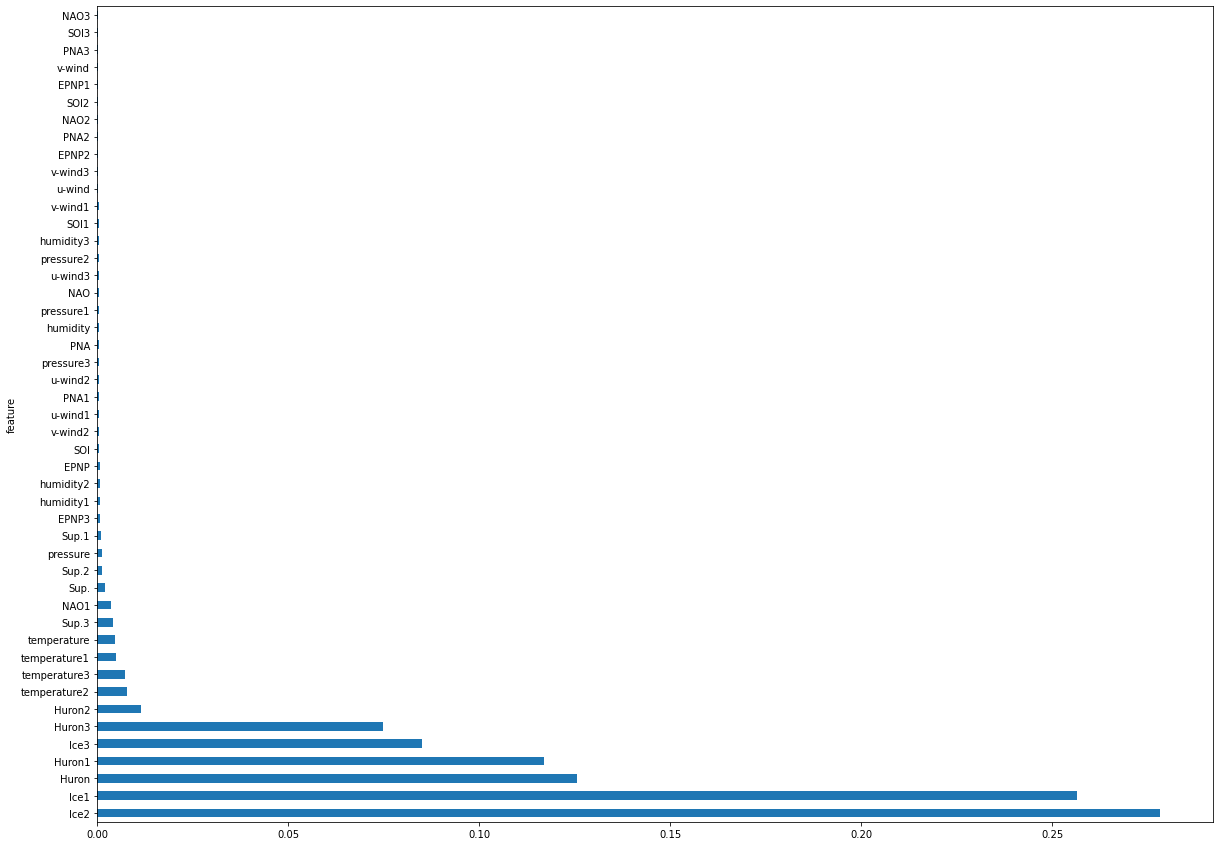

In [ ]:
# Calculating variable importance as per the XGBoost model.

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_test.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

# Displaying the variable importance

%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
df_var_imp['importance'].plot(kind = 'barh')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


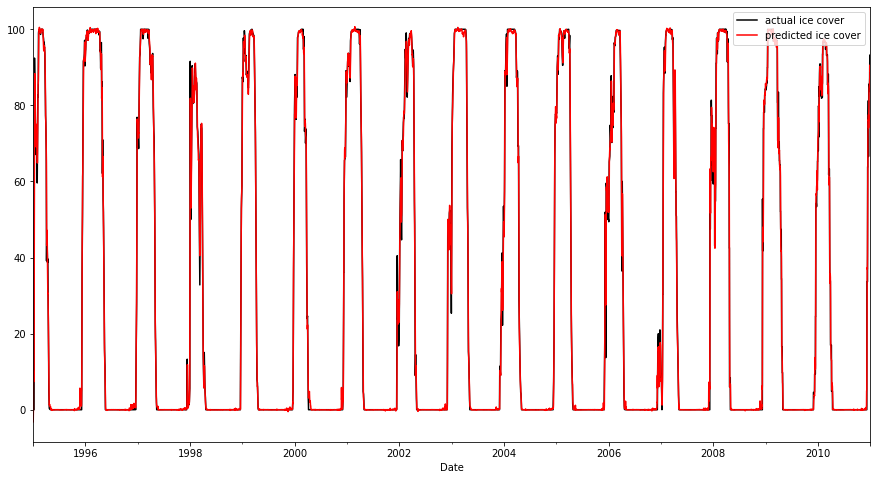

In [ ]:
# Overlaying the training predictions on top of training data

X_train['Ice'] = y_train
X_train['Ice_pred'] = y_train_pred

plt.figure(figsize=(15,8))
X_train['Ice'].plot(label = 'actual ice cover', color = 'black')
X_train['Ice_pred'].plot(label = 'predicted ice cover', color = 'red')
plt.legend(loc="upper right")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


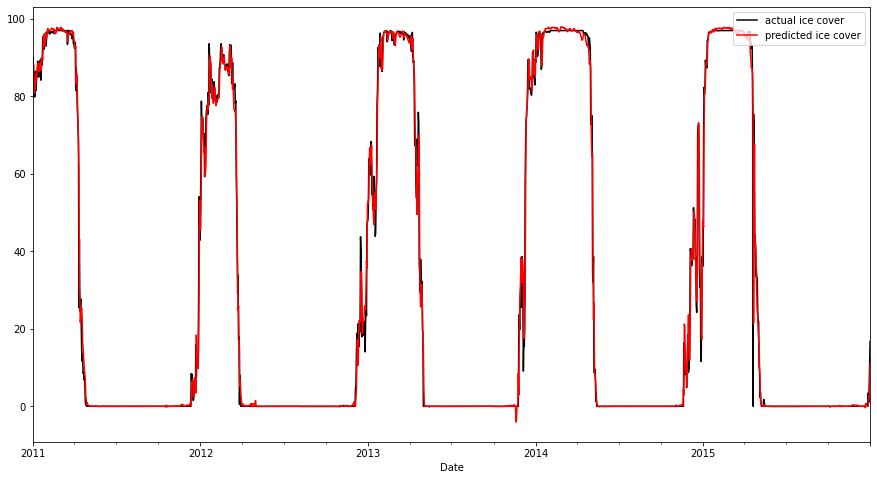

In [ ]:
# Overlaying the training predictions on top of validation data

X_valid['Ice'] = y_valid
X_valid['Ice_pred'] = y_valid_pred

plt.figure(figsize=(15,8))
X_valid['Ice'].plot(label = 'actual ice cover', color = 'black')
X_valid['Ice_pred'].plot(label = 'predicted ice cover', color = 'red')
plt.legend(loc="upper right")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


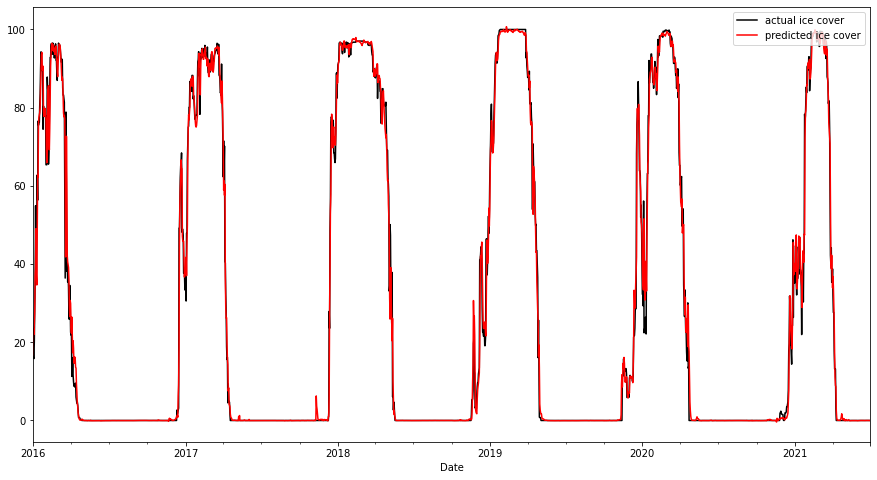

In [ ]:
# Overlaying the training predictions on top of validation data

X_test['Ice'] = y_test
X_test['Ice_pred'] = y_test_pred

plt.figure(figsize=(15,8))
X_test['Ice'].plot(label = 'actual ice cover', color = 'black')
X_test['Ice_pred'].plot(label = 'predicted ice cover', color = 'red')
plt.legend(loc="upper right")

In [ ]:
df_data_train.columns

Index(['Ice', 'Ice1', 'Ice2', 'Ice3', 'u-wind', 'v-wind', 'pressure',
       'humidity', 'temperature', 'u-wind1', 'v-wind1', 'pressure1',
       'humidity1', 'temperature1', 'u-wind2', 'v-wind2', 'pressure2',
       'humidity2', 'temperature2', 'u-wind3', 'v-wind3', 'pressure3',
       'humidity3', 'temperature3', 'Sup.', 'Huron', 'Sup.1', 'Huron1',
       'Sup.2', 'Huron2', 'Sup.3', 'Huron3', 'NAO', 'PNA', 'EPNP', 'SOI',
       'NAO1', 'PNA1', 'EPNP1', 'SOI1', 'NAO2', 'PNA2', 'EPNP2', 'SOI2',
       'NAO3', 'PNA3', 'EPNP3', 'SOI3'],
      dtype='object')

In [ ]:
### XGBoost model to forecast the ice for the next 7 days. Here we select 2019-01-15 as the split date

split_date = '2021-01-15'

df_data_train = df_data.loc[df_data.index < split_date].copy()
df_data_test = df_data.loc[df_data.index == split_date].copy()

df_data_train = pd.DataFrame(df_data_train[['Ice', 'Ice1', 'Ice2', 'Ice3', 
                                            'Huron', 'Huron1', 'Huron2', 'Huron3', 
                                            'Sup.', 'Sup.1', 'Sup.2', 'Sup.3', 
                                            'temperature', 'temperature1', 'temperature2', 'temperature3', 
                                            'pressure', 'NAO', 'EPNP', 'humidity']])

df_data_test = pd.DataFrame(df_data_test[['Ice', 'Ice1', 'Ice2', 'Ice3', 
                                            'Huron', 'Huron1', 'Huron2', 'Huron3', 
                                            'Sup.', 'Sup.1', 'Sup.2', 'Sup.3', 
                                            'temperature', 'temperature1', 'temperature2', 'temperature3', 
                                            'pressure', 'NAO', 'EPNP', 'humidity']])

X_train = df_data_train.drop(['Ice'], axis = 1)
X_test = df_data_test.drop(['Ice'], axis = 1)
y_train = df_data_train['Ice']
y_test = df_data_test['Ice']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

xgb1 = xgb.XGBRegressor()
parameters = {'objective' : ['reg:squarederror'],
              #'objective':['reg:tweedie'],
              'booster': ['gbtree'],
              'early_stopping_rounds' : [20],
              'learning_rate': [0.005],
              'max_depth': [2, 3],
              'subsample': [0.6], #, 0.7, 0.8],
              'colsample_bytree': [0.7], #[0.6, 0.7, 0.8],
              'n_estimators': [1200], #, 2000, 2500],
              'eval_metric' : ['rmse'],
              'eval_set' : [[X_test, y_test]]}

tscv = TimeSeriesSplit(n_splits=10)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

(9511, 19) (9511,)
(1, 19) (1,)
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.6min finished


0.9931029094963716
{'booster': 'gbtree', 'colsample_bytree': 0.7, 'early_stopping_rounds': 20, 'eval_metric': 'rmse', 'eval_set': [                 Ice1       Ice2       Ice3  ...       NAO      EPNP  humidity
Date                                         ...                              
2021-01-15  38.579701  37.417581  46.916322  ...  0.361888  0.315966  0.412174

[1 rows x 19 columns], Date
2021-01-15    38.078471
Name: Ice, dtype: float64], 'learning_rate': 0.005, 'max_depth': 3, 'n_estimators': 1200, 'objective': 'reg:squarederror', 'subsample': 0.6}


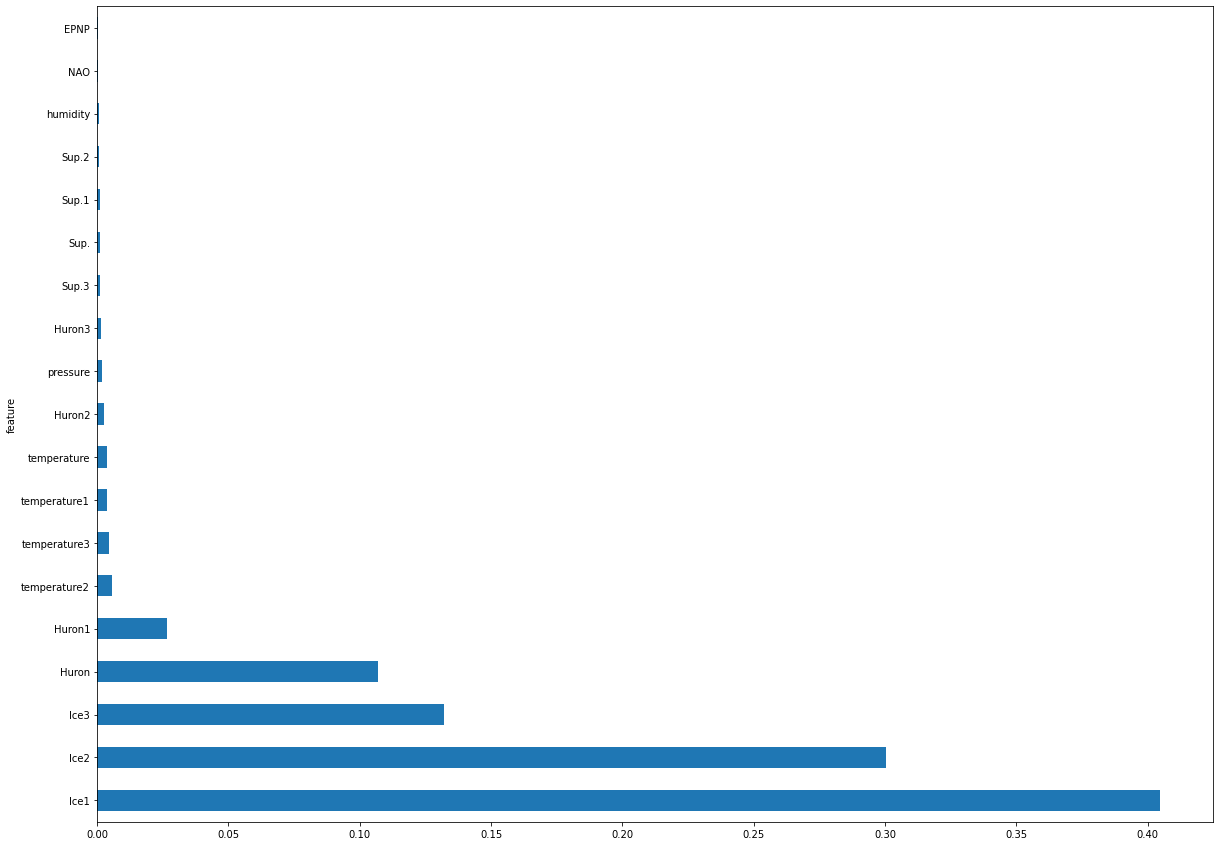

In [ ]:
# Calculating variable importance as per the XGBoost model.

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_test.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

# Displaying the variable importance

%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
df_var_imp['importance'].plot(kind = 'barh')

In [ ]:
### Predict ice cover on the day of the test data

y_test_pred = xgb_grid.predict(X_test)

y_test_pred

array([34.26803], dtype=float32)

In [ ]:
### Actual ice cover on the day of the test data

y_test

Date
2021-01-15    38.078471
Name: Ice, dtype: float64

In [ ]:
## calculating the mean absolute error

print(mean_absolute_error(y_test, y_test_pred))

3.8104424966348134


In [ ]:
X_train['Ice1'][(X_train['month'] == 1) & (X_train['day'] == 16)].mean()

82.56802163867593

In [ ]:
df_data['Ice'][(df_data.index.month == 1) & (df_data.index.day == 16)]

Date
1995-01-16    76.391908
1996-01-16    99.112057
1997-01-16    93.082707
1998-01-16    90.432960
1999-01-16    99.017631
2000-01-16    84.517953
2001-01-16    91.112331
2002-01-16    44.672250
2003-01-16    91.863492
2004-01-16    95.969204
2005-01-16    95.968539
2006-01-16    70.863957
2007-01-16    53.128653
2008-01-16    54.836687
2009-01-16    99.998459
2010-01-16    90.876943
2011-01-16    89.323543
2012-01-16    77.780854
2013-01-16    43.890192
2014-01-16    96.322688
2015-01-16    96.768919
2016-01-16    76.214717
2017-01-16    88.242272
2018-01-16    96.782432
2019-01-16    91.621516
2020-01-16    77.944046
2021-01-16    34.214102
Name: Ice, dtype: float64

In [ ]:
######### Using the predicted value on any date as ground truth and then forecast for next 30 days #################

from datetime import datetime, timedelta

X_train = X_train.reset_index()
X_train['month'] = X_train['Date'].dt.month
X_train['day'] = X_train['Date'].dt.day
X_train = X_train.set_index('Date')

#df_test = X_train[(X_train['month'] == X_test.index.month.values[0]) & (X_train['day'] == X_test.index.day.values[0])]
#df_test = df_test.dropna()

for i in range(1, 31):

  res = (datetime.strptime(split_date, '%Y-%m-%d') + timedelta(days=i)).strftime('%Y-%m-%d')
    
  df_data_test = df_data.loc[df_data.index == res].copy()

  df_test = X_train[(X_train['month'] == df_data_test.index.month.values[0]) & (X_train['day'] == df_data_test.index.day.values[0])]
  df_test = df_test.dropna()

  X_test['Ice3'] = X_test['Ice2']
  X_test['Ice2'] = X_test['Ice1']
  X_test['Ice1'] = y_test_pred
  
  X_test['Sup.3'] = df_test.groupby(['month', 'day'])['Sup.3'].mean().values
  X_test['Sup.2'] = df_test.groupby(['month', 'day'])['Sup.2'].mean().values
  X_test['Sup.1'] = df_test.groupby(['month', 'day'])['Sup.1'].mean().values
  X_test['Sup.'] = df_test.groupby(['month', 'day'])['Sup.'].mean().values
  
  X_test['Huron3'] = df_test.groupby(['month', 'day'])['Huron3'].mean().values
  X_test['Huron2'] = df_test.groupby(['month', 'day'])['Huron2'].mean().values
  X_test['Huron1'] = df_test.groupby(['month', 'day'])['Huron1'].mean().values
  X_test['Huron'] = df_test.groupby(['month', 'day'])['Huron'].mean().values

  X_test['temperature3'] = df_test.groupby(['month', 'day'])['temperature3'].mean().values
  X_test['temperature2'] = df_test.groupby(['month', 'day'])['temperature2'].mean().values
  X_test['temperature1'] = df_test.groupby(['month', 'day'])['temperature1'].mean().values
  X_test['temperature'] = df_test.groupby(['month', 'day'])['temperature'].mean().values

  X_test['pressure'] = df_test.groupby(['month', 'day'])['pressure'].mean().values
  X_test['NAO'] = df_test.groupby(['month', 'day'])['NAO'].mean().values
  X_test['EPNP'] = df_test.groupby(['month', 'day'])['EPNP'].mean().values
  X_test['humidity'] = df_test.groupby(['month', 'day'])['humidity'].mean().values
    
  y_test = df_data_test['Ice']
  
  y_test_pred = xgb_grid.predict(X_test)
    
  print(res, y_test, y_test_pred)

2021-01-16 Date
2021-01-16    34.214102
Name: Ice, dtype: float64 [88.73339]
2021-01-17 Date
2021-01-17    21.971418
Name: Ice, dtype: float64 [88.68969]
2021-01-18 Date
2021-01-18    37.702716
Name: Ice, dtype: float64 [88.581406]
2021-01-19 Date
2021-01-19    37.702716
Name: Ice, dtype: float64 [88.83931]
2021-01-20 Date
2021-01-20    39.269547
Name: Ice, dtype: float64 [89.28463]
2021-01-21 Date
2021-01-21    30.296469
Name: Ice, dtype: float64 [89.38671]
2021-01-22 Date
2021-01-22    42.377782
Name: Ice, dtype: float64 [89.274345]
2021-01-23 Date
2021-01-23    42.702259
Name: Ice, dtype: float64 [89.06998]
2021-01-24 Date
2021-01-24    78.322229
Name: Ice, dtype: float64 [89.07205]
2021-01-25 Date
2021-01-25    76.6464
Name: Ice, dtype: float64 [89.08781]
2021-01-26 Date
2021-01-26    77.943481
Name: Ice, dtype: float64 [89.20876]
2021-01-27 Date
2021-01-27    81.810193
Name: Ice, dtype: float64 [89.12836]
2021-01-28 Date
2021-01-28    85.269658
Name: Ice, dtype: float64 [89.0643]


In [ ]:
print(mean_absolute_error(y_test, y_test_pred))

10.00706708753431


In [ ]:
X_test

Ice1       Ice2       Ice3  ...      PNA3    EPNP3      SOI3
Date                                         ...                             
2021-02-15  99.603706  99.603706  99.603706  ...  0.435841  0.30084  0.766667

[1 rows x 47 columns]

In [ ]:
df_period = df_data.reset_index()
df_period['year'] = pd.DatetimeIndex(df_period['Date']).year
df_period['month'] = pd.DatetimeIndex(df_period['Date']).month
df_period['day'] = pd.DatetimeIndex(df_period['Date']).day
df_period = df_period.set_index('Date')
df_period.tail()

Ice  Ice1  Ice2  Ice3    u-wind    v-wind  pressure  humidity  \
Date                                                                        
2021-06-26  0.0   0.0   0.0   0.0  0.427313  0.540233  0.454510  0.457391   
2021-06-27  0.0   0.0   0.0   0.0  0.453114  0.452684  0.406305  0.697391   
2021-06-28  0.0   0.0   0.0   0.0  0.546229  0.513905  0.564749  0.551304   
2021-06-29  0.0   0.0   0.0   0.0  0.473042  0.607013  0.604711  0.615652   
2021-06-30  0.0   0.0   0.0   0.0  0.601301  0.523049  0.537169  0.568696   

            temperature   u-wind1   v-wind1  pressure1  humidity1  \
Date                                                                
2021-06-26     0.777870  0.462518  0.629235   0.481151   0.605217   
2021-06-27     0.793817  0.427313  0.540233   0.454510   0.457391   
2021-06-28     0.839706  0.453114  0.452684   0.406305   0.697391   
2021-06-29     0.830244  0.546229  0.513905   0.564749   0.551304   
2021-06-30     0.818099  0.473042  0.607013   0.604711   0.615652   

            temperature1   u-wind2   v-wind2  pressure2  humidity2  \
Date                                                                 
2021-06-26      0.767096  0.611472  0.784246   0.472128   0.518261   
2021-06-27      0.777870  0.462518  0.629235   0.481151   0.605217   
2021-06-28      0.793817  0.427313  0.540233   0.454510   0.457391   
2021-06-29      0.839706  0.453114  0.452684   0.406305   0.697391   
2021-06-30      0.830244  0.546229  0.513905   0.564749   0.551304   

            temperature2   u-wind3   v-wind3  pressure3  humidity3  \
Date                                                                 
2021-06-26      0.798457  0.539980  0.649380   0.512442   0.330435   
2021-06-27      0.767096  0.611472  0.784246   0.472128   0.518261   
2021-06-28      0.777870  0.462518  0.629235   0.481151   0.605217   
2021-06-29      0.793817  0.427313  0.540233   0.454510   0.457391   
2021-06-30      0.839706  0.453114  0.452684   0.406305   0.697391   

            temperature3      Sup.     Huron     Sup.1    Huron1     Sup.2  \
Date                                                                         
2021-06-26      0.716457  0.461155  0.644060  0.423805  0.625887  0.400896   
2021-06-27      0.798457  0.501494  0.660904  0.461155  0.644060  0.423805   
2021-06-28      0.767096  0.533865  0.673316  0.501494  0.660904  0.461155   
2021-06-29      0.777870  0.555777  0.689716  0.533865  0.673316  0.501494   
2021-06-30      0.793817  0.561255  0.697252  0.555777  0.689716  0.533865   

              Huron2     Sup.3    Huron3       NAO       PNA      EPNP  \
Date                                                                     
2021-06-26  0.609486  0.383466  0.603280  0.690559  0.652655  0.391597   
2021-06-27  0.625887  0.400896  0.609486  0.690559  0.652655  0.391597   
2021-06-28  0.644060  0.423805  0.625887  0.690559  0.652655  0.391597   
2021-06-29  0.660904  0.461155  0.644060  0.690559  0.652655  0.391597   
2021-06-30  0.673316  0.501494  0.660904  0.690559  0.652655  0.391597   

                 SOI      NAO1      PNA1     EPNP1      SOI1      NAO2  \
Date                                                                     
2021-06-26  0.583333  0.690559  0.652655  0.391597  0.583333  0.690559   
2021-06-27  0.583333  0.690559  0.652655  0.391597  0.583333  0.690559   
2021-06-28  0.583333  0.690559  0.652655  0.391597  0.583333  0.690559   
2021-06-29  0.583333  0.690559  0.652655  0.391597  0.583333  0.690559   
2021-06-30  0.583333  0.690559  0.652655  0.391597  0.583333  0.690559   

                PNA2     EPNP2      SOI2      NAO3      PNA3     EPNP3  \
Date                                                                     
2021-06-26  0.652655  0.391597  0.583333  0.690559  0.652655  0.391597   
2021-06-27  0.652655  0.391597  0.583333  0.690559  0.652655  0.391597   
2021-06-28  0.652655  0.391597  0.583333  0.690559  0.652655  0.391597   
2021-06-29  0.652655  0.391597  0.583333  0.690559 

In [ ]:
########## Freezing Phase: Nov 01 - Jan 14
########## Stable Phase: Jan 15 - Mar 25
########## Melting Phase: Mar 26 - May 10
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_freezing = df_period[df_period['month'].isin([11, 12, 1])]
#df_freezing = df_freezing[~((df_freezing['month'] == 11) & (df_freezing['day'] < 25))]
df_freezing = df_freezing[~((df_freezing['month'] == 1) & (df_freezing['day'] > 14))]

In [ ]:
df_stable = df_period[df_period['month'].isin([1, 2, 3])]
df_stable = df_stable[~((df_stable['month'] == 1) & (df_stable['day'] < 15))]
df_stable = df_stable[~((df_stable['month'] == 3) & (df_stable['day'] > 25))]

In [ ]:
df_melting = df_period[df_period['month'].isin([3, 4, 5])]
df_melting = df_melting[~((df_melting['month'] == 3) & (df_melting['day'] < 26))]
df_melting = df_melting[~((df_melting['month'] == 5) & (df_melting['day'] > 10))]

In [ ]:
df_freezing.tail()

Ice       Ice1       Ice2       Ice3    u-wind    v-wind  \
Date                                                                         
2021-01-10  42.457084  44.403590  36.728748  36.241747  0.572967  0.493280   
2021-01-11  46.916322  42.457084  44.403590  36.728748  0.616187  0.661790   
2021-01-12  46.916322  46.916322  42.457084  44.403590  0.542318  0.588856   
2021-01-13  37.417581  46.916322  46.916322  42.457084  0.608257  0.646013   
2021-01-14  38.579701  37.417581  46.916322  46.916322  0.452894  0.605881   

            pressure  humidity  temperature   u-wind1   v-wind1  pressure1  \
Date                                                                         
2021-01-10  0.677721  0.453913     0.440072  0.536959  0.396920   0.683855   
2021-01-11  0.591273  0.290435     0.430886  0.572967  0.493280   0.677721   
2021-01-12  0.504395  0.346087     0.415870  0.616187  0.661790   0.591273   
2021-01-13  0.377866  0.394783     0.460610  0.542318  0.588856   0.504395   
2021-01-14  0.339193  0.325217     0.454602  0.608257  0.646013   0.377866   

            humidity1  temperature1   u-wind2   v-wind2  pressure2  humidity2  \
Date                                                                            
2021-01-10   0.278261      0.365538  0.454648  0.398517   0.744014   0.092174   
2021-01-11   0.453913      0.440072  0.536959  0.396920   0.683855   0.278261   
2021-01-12   0.290435      0.430886  0.572967  0.493280   0.677721   0.453913   
2021-01-13   0.346087      0.415870  0.616187  0.661790   0.591273   0.290435   
2021-01-14   0.394783      0.460610  0.542318  0.588856   0.504395   0.346087   

            temperature2   u-wind3   v-wind3  pressure3  humidity3  \
Date                                                                 
2021-01-10      0.345074  0.412683  0.410288   0.792023   0.130435   
2021-01-11      0.365538  0.454648  0.398517   0.744014   0.092174   
2021-01-12      0.440072  0.536959  0.396920   0.683855   0.278261   
2021-01-13      0.430886  0.572967  0.493280   0.677721   0.453913   
2021-01-14      0.415870  0.616187  0.661790   0.591273   0.290435   

            temperature3      Sup.     Huron     Sup.1    Huron1     Sup.2  \
Date                                                                         
2021-01-10      0.397355  0.166833  0.160018  0.168327  0.160018  0.169323   
2021-01-11      0.345074  0.165339  0.160461  0.166833  0.160018  0.168327   
2021-01-12      0.365538  0.165339  0.160461  0.165339  0.160461  0.166833   
2021-01-13      0.440072  0.163347  0.159131  0.165339  0.160461  0.165339   
2021-01-14      0.430886  0.159861  0.156915  0.163347  0.159131  0.165339   

              Huron2     Sup.3    Huron3       NAO      PNA      EPNP  \
Date                                                                    
2021-01-10  0.166667  0.172311  0.169770  0.361888  0.54646  0.315966   
2021-01-11  0.160018  0.169323  0.166667  0.361888  0.54646  0.315966   
2021-01-12  0.160018  0.168327  0.160018  0.361888  0.54646  0.315966   
2021-01-13  0.160461  0.166833  0.160018  0.361888  0.54646  0.315966   
2021-01-14  0.160461  0.165339  0.160461  0.361888  0.54646  0.315966   

                 SOI      NAO1     PNA1     EPNP1      SOI1      NAO2  \
Date                                                                    
2021-01-10  0.833333  0.361888  0.54646  0.315966  0.833333  0.361888   
2021-01-11  0.833333  0.361888  0.54646  0.315966  0.833333  0.361888   
2021-01-12  0.833333  0.361888  0.54646  0.315966  0.833333  0.361888   
2021-01-13  0.833333  0.361888  0.54646  0.315966  0.833333  0.361888   
2021-01-14  0.833333  0.361888  0.54646  0.315966  0.833333  0.361888   

               PNA2     EPNP2      SOI2      NAO3     PNA3     EPNP3  \
Date                                                                   
2021-01-10  0.54646  0.315966  0.833333  0.361888  0.54646  0.315966   
2021-01-11  0.54646  0.315966  0.833333  0.361888  0.54646  0.315966   
2021-0

#### Training XGBoost Model on freezing period

In [ ]:
# Separating the Independent and dependent variables

X = df_freezing.drop(['Ice'], axis = 1)
y = df_freezing['Ice']

X = X.drop(['year', 'month', 'day'], axis = 1)

In [ ]:
########## Freezing Phase: Nov 01 - Jan 14
########## Stable Phase: Jan 15 - Mar 25
########## Melting Phase: Mar 26 - May 10
X_train = X['1995-11-01':'2010-01-14']
X_valid = X['2011-11-01':'2015-01-14']
y_train = y['1995-11-01':'2010-01-14']
y_valid = y['2011-11-01':'2015-01-14']
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(1125, 47) (1125,)
(300, 47) (300,)


In [ ]:
X_test = X['2016-11-01':'2021-01-14']
y_test = y['2016-11-01':'2021-01-14']
print(X_valid.shape, y_valid.shape)

(300, 47) (300,)


In [ ]:
# Running the XGBoost regressor with a wide range of hyper parameters and 10 CV timeseries splits

t0 = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'objective' : ['reg:squarederror'],
              #'objective':['reg:tweedie'],
              'booster': ['gbtree'],
              'early_stopping_rounds' : [20],
              'learning_rate': [0.001],
              'max_depth': [3],
              'subsample': [0.7, 0.8],
              'colsample_bytree': [0.5, 0.6],
              'n_estimators': [2000],
              'eval_metric' : ['rmse'],
              'eval_set' : [[X_valid, y_valid]]}

tscv = TimeSeriesSplit(n_splits=10)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=False)

xgb_grid.fit(X_train, y_train)

tF = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

print('Time to train = %.2f seconds' % (tF - t0))

0.9412439437559087
{'booster': 'gbtree', 'colsample_bytree': 0.6, 'early_stopping_rounds': 20, 'eval_metric': 'rmse', 'eval_set': [                 Ice1       Ice2       Ice3    u-wind    v-wind  pressure  \
Date                                                                        
2011-11-01   0.000000   0.000000   0.000000  0.540784  0.685477  0.573226   
2011-11-02   0.000000   0.000000   0.000000  0.508941  0.584139  0.541779   
2011-11-03   0.000000   0.000000   0.000000  0.557204  0.345859  0.590609   
2011-11-04   0.000000   0.000000   0.000000  0.473225  0.487315  0.693777   
2011-11-05   0.000000   0.000000   0.000000  0.423890  0.718323  0.714129   
2011-11-06   0.000000   0.000000   0.000000  0.419115  0.780937  0.559826   
2011-11-07   0.000000   0.000000   0.000000  0.670236  0.731632  0.517286   
2011-11-08   0.000000   0.000000   0.000000  0.545449  0.525443  0.638384   
2011-11-09   0.000000   0.000000   0.000000  0.306217  0.356411  0.502676   
2011-11-10   0.000000 

In [ ]:
# Predicting on the training data and calculating the mean absolute error

y_train_pred = xgb_grid.predict(X_train)

print(mean_absolute_error(y_train, y_train_pred))
print(math.sqrt(mean_squared_error(y_train, y_train_pred)))

4.4474905686971296
7.269849564400402


In [ ]:
# Predicting on the validation data and calculating the mean absolute error

y_valid_pred = xgb_grid.predict(X_valid)

print(mean_absolute_error(y_valid, y_valid_pred))
print(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

5.6640933609502815
9.110035819003588


In [ ]:
# Predicting on the testation data and calculating the mean absolute error

y_test_pred = xgb_grid.predict(X_test)
y_test_pred[y_test_pred < 0] = 0

print(mean_absolute_error(y_test, y_test_pred))
print(math.sqrt(mean_squared_error(y_test, y_test_pred)))

4.937414022193943
8.418799178137684


In [ ]:
df_train = X_train.copy()
df_train['y_train'] = y_train
df_train['y_train_pred'] = y_train_pred

df_valid = X_valid.copy()
df_valid['y_valid'] = y_valid
df_valid['y_valid_pred'] = y_valid_pred

df_test = X_test.copy()
df_test['y_test'] = y_test
df_test['y_test_pred'] = y_test_pred

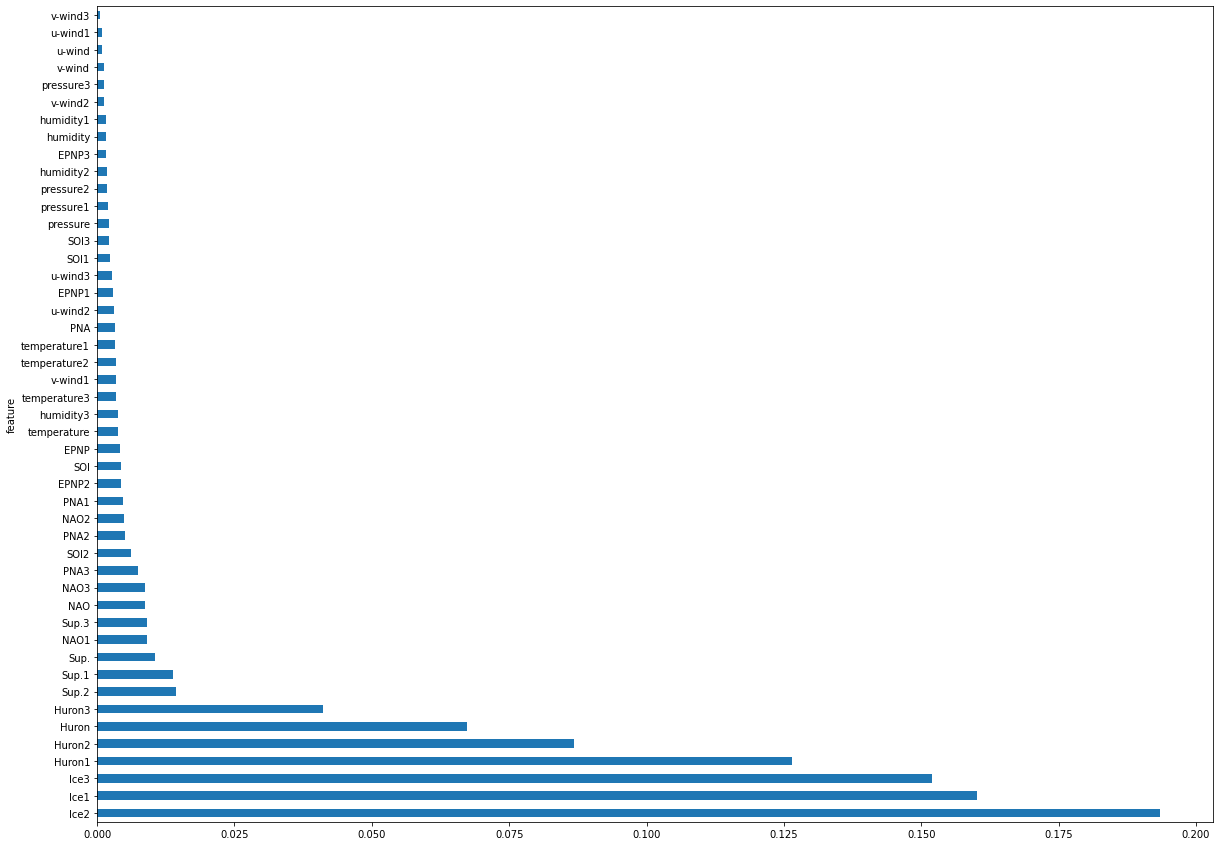

In [ ]:
# Calculating variable importance as per the XGBoost model.

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_valid.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

# Displaying the variable importance

%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
df_var_imp['importance'].plot(kind = 'barh')

In [ ]:
y_train.tail()

Date
2010-01-10    82.431086
2010-01-11    82.431086
2010-01-12    88.390409
2010-01-13    89.647192
2010-01-14    90.876943
Name: Ice, dtype: float64

In [ ]:
y_train = pd.DataFrame(y_train)
y_train = y_train.reset_index()
y_train.columns = ['Date', 'Ice']

y_train_pred = pd.DataFrame(y_train_pred)
y_train_pred['Date'] = y_train['Date']
y_train_pred.columns = ['Ice', 'Date']

from datetime import datetime
df_date = pd.DataFrame(pd.date_range(start="1995-01-01",end="2010-12-31"))
df_date.columns = ['Date']

y_train = pd.merge(df_date, y_train, on = 'Date', how = 'outer')

y_train_pred = pd.merge(df_date, y_train_pred, on = 'Date', how = 'outer')
y_train_pred

Date  Ice
0 1995-11-01  0.0
1 1995-11-02  0.0
2 1995-11-03  0.0
3 1995-11-04  0.0
4 1995-11-05  0.0

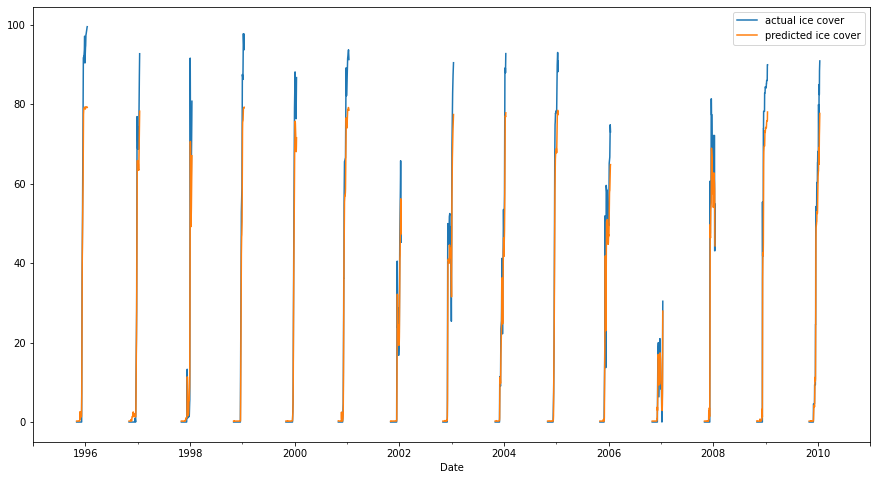

In [ ]:
# Overlaying the training predictions on top of training data
plt.figure(figsize=(15,8))

y_train = y_train.set_index('Date')
y_train_pred = y_train_pred.set_index('Date')
y_train['Ice'].plot(label = 'actual ice cover')
y_train_pred['Ice'].plot(label = 'predicted ice cover')
plt.legend(loc="upper right")

In [ ]:
df_var_imp['importance']

feature
Ice2            0.193445
Ice1            0.160068
Ice3            0.151983
Huron1          0.126420
Huron2          0.086865
Huron           0.067290
Huron3          0.041154
Sup.2           0.014380
Sup.1           0.013750
Sup.            0.010580
NAO1            0.009156
Sup.3           0.009139
NAO             0.008767
NAO3            0.008653
PNA3            0.007433
SOI2            0.006245
PNA2            0.005135
NAO2            0.004950
PNA1            0.004691
EPNP2           0.004425
SOI             0.004317
EPNP            0.004174
temperature     0.003847
humidity3       0.003818
temperature3    0.003477
v-wind1         0.003472
temperature2    0.003408
temperature1    0.003313
PNA             0.003212
u-wind2         0.003156
EPNP1           0.002858
u-wind3         0.002646
SOI1            0.002406
SOI3            0.002233
pressure        0.002224
pressure1       0.001928
pressure2       0.001861
humidity2       0.001798
EPNP3           0.001709
humidity        0

In [ ]:
### XGBoost model to forecast the ice for the next 14 days. Here we select 2019-01-01 as the 
### test data set.

split_date = '2020-12-25'

df_freeze_train = df_freezing.loc[df_freezing.index < split_date].copy()
df_freeze_test = df_freezing.loc[df_freezing.index == split_date].copy()

df_freeze_train = pd.DataFrame(df_freeze_train[['Ice', 'Ice1', 'Ice2', 'Ice3', 
                                                'Huron', 'Huron1', 'Huron2', 'Huron3', 
                                                'Sup.', 'Sup.1', 'Sup.2', 'Sup.3', 
                                                'NAO', 'NAO1', 'NAO2', 'NAO3', 
                                                'pressure', 'EPNP', 'humidity', 'temperature']])

df_freeze_test = pd.DataFrame(df_freeze_test[['Ice', 'Ice1', 'Ice2', 'Ice3', 
                                              'Huron', 'Huron1', 'Huron2', 'Huron3', 
                                              'Sup.', 'Sup.1', 'Sup.2', 'Sup.3', 
                                              'NAO', 'NAO1', 'NAO2', 'NAO3', 
                                              'pressure', 'EPNP', 'humidity', 'temperature']])

X_train = df_freeze_train.drop(['Ice'], axis = 1)
X_test = df_freeze_test.drop(['Ice'], axis = 1)
y_train = df_freeze_train['Ice']
y_test = df_freeze_test['Ice']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

xgb1 = xgb.XGBRegressor()

parameters = {'objective' : ['reg:squarederror'],
              #'objective':['reg:tweedie'],
              'booster': ['gbtree'],
              'early_stopping_rounds' : [20],
              'learning_rate': [0.001],
              'max_depth': [3],
              'subsample': [0.6, 0.7, 0.8],
              'colsample_bytree': [0.6, 0.7, 0.8],
              'n_estimators': [2500],
              'eval_metric' : ['rmse'],
              'eval_set' : [[X_test, y_test]]}

tscv = TimeSeriesSplit(n_splits=10)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

(1943, 19) (1943,)
(1, 19) (1,)
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.6min finished


0.9528368626120006
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'early_stopping_rounds': 20, 'eval_metric': 'rmse', 'eval_set': [                 Ice1       Ice2       Ice3     Huron    Huron1   Huron2  \
Date                                                                       
2020-12-25  14.404358  16.714825  19.417591  0.203457  0.207447  0.21055   

              Huron3      Sup.     Sup.1     Sup.2     Sup.3       NAO  \
Date                                                                     
2020-12-25  0.211879  0.184761  0.190239  0.192729  0.197709  0.503497   

                NAO1      NAO2      NAO3  pressure      EPNP  humidity  \
Date                                                                     
2020-12-25  0.503497  0.503497  0.503497  0.352631  0.431933  0.347826   

            temperature  
Date                     
2020-12-25     0.329447  , Date
2020-12-25    24.270012
Name: Ice, dtype: float64], 'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 25

In [ ]:
### Predict ice cover on the day of the test data

y_test_pred = xgb_grid.predict(X_test)

y_test_pred

array([18.756243], dtype=float32)

In [ ]:
### Actual ice cover on the day of the test data

y_test

Date
2020-12-25    24.270012
Name: Ice, dtype: float64

In [ ]:
## calculating the mean absolute error

print(mean_absolute_error(y_test, y_test_pred))

5.513768861100484


In [ ]:
X_test.columns

Index(['Ice1', 'Ice2', 'Ice3', 'Huron', 'Huron1', 'Huron2', 'Huron3', 'Sup.',
       'Sup.1', 'Sup.2', 'Sup.3', 'NAO', 'NAO1', 'NAO2', 'NAO3', 'pressure',
       'EPNP', 'humidity', 'temperature'],
      dtype='object')

In [ ]:
######### Using the predicted value on any date as ground truth and then forecast for next 14 days #################

from datetime import datetime, timedelta

X_train = X_train.reset_index()
X_train['month'] = X_train['Date'].dt.month
X_train['day'] = X_train['Date'].dt.day
X_train = X_train.set_index('Date')

for i in range(1, 15):

  res = (datetime.strptime(split_date, '%Y-%m-%d') + timedelta(days=i)).strftime('%Y-%m-%d')
    
  df_data_test = df_freezing.loc[df_freezing.index == res].copy()

  df_test = X_train[(X_train['month'] == df_data_test.index.month.values[0]) & (X_train['day'] == df_data_test.index.day.values[0])]
  df_test = df_test.dropna()

  X_test['Ice3'] = X_test['Ice2']
  X_test['Ice2'] = X_test['Ice1']
  X_test['Ice1'] = y_test_pred
  
  X_test['Sup.3'] = df_test.groupby(['month', 'day'])['Sup.3'].mean().values
  X_test['Sup.2'] = df_test.groupby(['month', 'day'])['Sup.2'].mean().values
  X_test['Sup.1'] = df_test.groupby(['month', 'day'])['Sup.1'].mean().values
  X_test['Sup.'] = df_test.groupby(['month', 'day'])['Sup.'].mean().values
  
  X_test['Huron3'] = df_test.groupby(['month', 'day'])['Huron3'].mean().values
  X_test['Huron2'] = df_test.groupby(['month', 'day'])['Huron2'].mean().values
  X_test['Huron1'] = df_test.groupby(['month', 'day'])['Huron1'].mean().values
  X_test['Huron'] = df_test.groupby(['month', 'day'])['Huron'].mean().values

  X_test['NAO3'] = df_test.groupby(['month', 'day'])['NAO3'].mean().values
  X_test['NAO2'] = df_test.groupby(['month', 'day'])['NAO2'].mean().values
  X_test['NAO1'] = df_test.groupby(['month', 'day'])['NAO1'].mean().values
  X_test['NAO'] = df_test.groupby(['month', 'day'])['NAO'].mean().values

  X_test['pressure'] = df_test.groupby(['month', 'day'])['pressure'].mean().values
  X_test['temperature'] = df_test.groupby(['month', 'day'])['temperature'].mean().values
  X_test['EPNP'] = df_test.groupby(['month', 'day'])['EPNP'].mean().values
  X_test['humidity'] = df_test.groupby(['month', 'day'])['humidity'].mean().values
    
  y_test = df_data_test['Ice']
  
  y_test_pred = xgb_grid.predict(X_test)
    
  print(res, y_test, y_test_pred)

2020-12-26 Date
2020-12-26    24.270012
Name: Ice, dtype: float64 [25.21846]
2020-12-27 Date
2020-12-27    46.20303
Name: Ice, dtype: float64 [30.170074]
2020-12-28 Date
2020-12-28    26.349741
Name: Ice, dtype: float64 [35.971165]
2020-12-29 Date
2020-12-29    39.406298
Name: Ice, dtype: float64 [40.879322]
2020-12-30 Date
2020-12-30    37.459853
Name: Ice, dtype: float64 [44.82822]
2020-12-31 Date
2020-12-31    35.121775
Name: Ice, dtype: float64 [50.656994]
2021-01-01 Date
2021-01-01    35.647873
Name: Ice, dtype: float64 [54.216522]
2021-01-02 Date
2021-01-02    44.647313
Name: Ice, dtype: float64 [56.057274]
2021-01-03 Date
2021-01-03    44.485093
Name: Ice, dtype: float64 [56.96486]
2021-01-04 Date
2021-01-04    34.997084
Name: Ice, dtype: float64 [59.547153]
2021-01-05 Date
2021-01-05    32.105606
Name: Ice, dtype: float64 [61.19024]
2021-01-06 Date
2021-01-06    37.106424
Name: Ice, dtype: float64 [64.2341]
2021-01-07 Date
2021-01-07    36.241747
Name: Ice, dtype: float64 [66.6

### Modeling for Stable Period

In [ ]:
# Separating the Independent and dependent variables

X = df_stable.drop(['Ice'], axis = 1)
y = df_stable['Ice']

X = X.drop(['year', 'month', 'day'], axis = 1)

In [ ]:
########## Stable Phase: Jan 15 - Mar 25

X_train = X['1995-01-15':'2010-03-25']
X_valid = X['2011-01-15':'2015-03-25']
y_train = y['1995-01-15':'2010-03-25']
y_valid = y['2011-01-15':'2015-03-25']
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(1124, 47) (1124,)
(351, 47) (351,)


In [ ]:
X_test = X['2016-01-15':'2021-03-25']
y_test = y['2016-01-15':'2021-03-25']
print(X_valid.shape, y_valid.shape)

(351, 47) (351,)


In [ ]:
# Running the XGBoost regressor with a wide range of hyper parameters and 10 CV timeseries splits

t0 = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'objective' : ['reg:squarederror'],
              #'objective':['reg:tweedie'],
              'booster': ['gbtree'],
              'early_stopping_rounds' : [20],
              'learning_rate': [0.001],
              'max_depth': [3],
              'subsample': [0.7, 0.8],
              'colsample_bytree': [0.5, 0.6],
              'n_estimators': [3000],
              'eval_metric' : ['rmse'],
              'eval_set' : [[X_valid, y_valid]]}

tscv = TimeSeriesSplit(n_splits=10)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=False)

xgb_grid.fit(X_train, y_train)

tF = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

print('Time to train = %.2f seconds' % (tF - t0))

-2.8104808158589796
{'booster': 'gbtree', 'colsample_bytree': 0.6, 'early_stopping_rounds': 20, 'eval_metric': 'rmse', 'eval_set': [                 Ice1       Ice2       Ice3    u-wind    v-wind  pressure  \
Date                                                                        
2011-01-15  85.133420  84.998770  85.539200  0.501498  0.533049  0.466972   
2011-01-16  88.566237  85.133420  84.998770  0.520903  0.389213  0.622681   
2011-01-17  89.323543  88.566237  85.133420  0.452626  0.775407  0.556545   
2011-01-18  88.647931  89.323543  88.566237  0.503886  0.530828  0.360795   
2011-01-19  84.214611  88.647931  89.323543  0.409918  0.349851  0.569788   
2011-01-20  89.836318  84.214611  88.647931  0.493130  0.552991  0.518614   
2011-01-21  88.025908  89.836318  84.214611  0.613933  0.316700  0.389742   
2011-01-22  88.998839  88.025908  89.836318  0.329630  0.402290  0.445369   
2011-01-23  94.755363  88.998839  88.025908  0.427801  0.383901  0.639712   
2011-01-24  95.404181

In [ ]:
# Predicting on the training data and calculating the mean absolute error

y_train_pred = xgb_grid.predict(X_train)

print(mean_absolute_error(y_train, y_train_pred))
print(math.sqrt(mean_squared_error(y_train, y_train_pred)))

4.799285606211098
5.072115683439098


In [ ]:
# Predicting on the validation data and calculating the mean absolute error

y_valid_pred = xgb_grid.predict(X_valid)

print(mean_absolute_error(y_valid, y_valid_pred))
print(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

4.971177165477244
5.485489166096358


In [ ]:
# Predicting on the testation data and calculating the mean absolute error

y_test_pred = xgb_grid.predict(X_test)
y_test_pred[y_test_pred < 0] = 0

print(mean_absolute_error(y_test, y_test_pred))
print(math.sqrt(mean_squared_error(y_test, y_test_pred)))

5.3519738173017535
6.444641793674608


In [ ]:
df_train = X_train.copy()
df_train['y_train'] = y_train
df_train['y_train_pred'] = y_train_pred

df_valid = X_valid.copy()
df_valid['y_valid'] = y_valid
df_valid['y_valid_pred'] = y_valid_pred

df_test = X_test.copy()
df_test['y_test'] = y_test
df_test['y_test_pred'] = y_test_pred

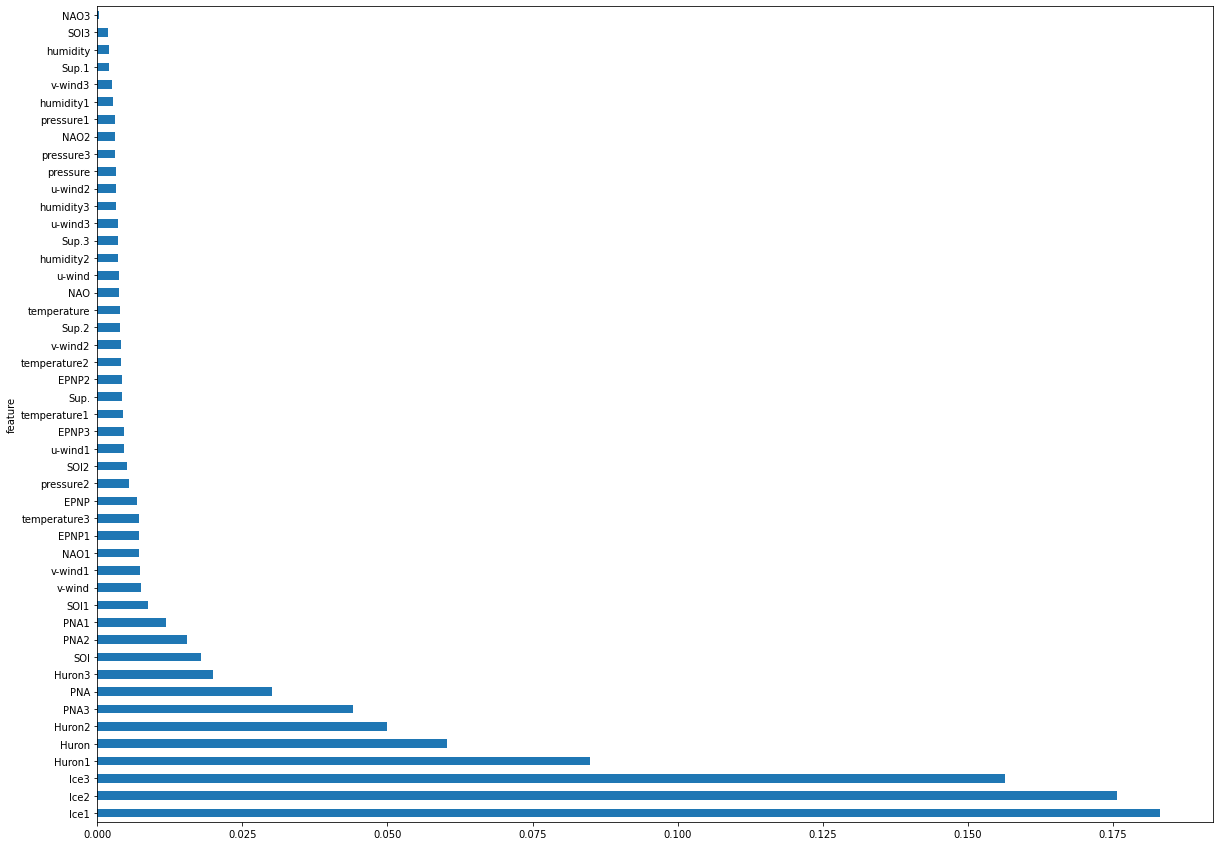

In [ ]:
# Calculating variable importance as per the XGBoost model.

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_valid.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

# Displaying the variable importance

%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
df_var_imp['importance'].plot(kind = 'barh')

In [ ]:
y_train.tail()

Date
2010-03-21    63.321685
2010-03-22    63.321685
2010-03-23    48.309528
2010-03-24    40.539282
2010-03-25    33.889997
Name: Ice, dtype: float64

In [ ]:
y_train = pd.DataFrame(y_train)
y_train = y_train.reset_index()
y_train.columns = ['Date', 'Ice']

y_train_pred = pd.DataFrame(y_train_pred)
y_train_pred['Date'] = y_train['Date']
y_train_pred.columns = ['Ice', 'Date']

from datetime import datetime
df_date = pd.DataFrame(pd.date_range(start="1995-01-01",end="2010-12-31"))
df_date.columns = ['Date']

y_train = pd.merge(df_date, y_train, on = 'Date', how = 'outer')

y_train_pred = pd.merge(df_date, y_train_pred, on = 'Date', how = 'outer')
y_train_pred

Date        Ice
0    1995-01-01        NaN
1    1995-01-02        NaN
2    1995-01-03        NaN
3    1995-01-04        NaN
4    1995-01-05        NaN
5    1995-01-06        NaN
6    1995-01-07        NaN
7    1995-01-08        NaN
8    1995-01-09        NaN
9    1995-01-10        NaN
10   1995-01-11        NaN
11   1995-01-12        NaN
12   1995-01-13        NaN
13   1995-01-14        NaN
14   1995-01-15  79.096588
15   1995-01-16  75.668961
16   1995-01-17  73.112373
17   1995-01-18  71.576965
18   1995-01-19  69.472733
19   1995-01-20  68.331802
20   1995-01-21  67.084145
21   1995-01-22  66.513069
22   1995-01-23  66.210320
23   1995-01-24  67.026321
24   1995-01-25  68.062050
25   1995-01-26  69.650063
26   1995-01-27  69.203072
27   1995-01-28  67.768661
28   1995-01-29  65.959419
29   1995-01-30  61.745403
30   1995-01-31  61.605770
31   1995-02-01  65.783615
32   1995-02-02  68.292458
33   1995-02-03  71.282417
34   1995-02-04  77.342133
35   1995-02-05  79.882576
36   1995-02-06  81.352989
37   1995-02-07  81.937790
38   1995-02-08  87.440681
39   1995-02-09  92.270302
40   1995-02-10  93.827232
41   1995-02-11  94.658821
42   1995-02-12  94.702042
43   1995-02-13  94.704811
44   1995-02-14  94.704811
45   1995-02-15  94.703690
46   1995-02-16  94.703995
47   1995-02-17  94.703087
48   1995-02-18  94.698257
49   1995-02-19  94.696945
50   1995-02-20  94.694473
51   1995-02-21  94.634827
52   1995-02-22  94.473816
53   1995-02-23  94.283226
54   1995-02-24  94.467018
55   1995-02-25  94.654686
56   1995-02-26  94.702148
57   1995-02-27  94.703911
58   1995-02-28  94.703011
59   1995-03-01  94.704811
60   1995-03-02  94.704811
61   1995-03-03  94.704811
62   1995-03-04  94.701874
63   1995-03-05  94.703308
64   1995-03-06  94.701248
65   1995-03-07  94.703293
66   1995-03-08  94.704811
67   1995-03-09  94.704811
68   1995-03-10  94.704811
69   1995-03-11  94.536850
70   1995-03-12  94.273987
71   1995-03-13  94.100372
72   1995-03-14  93.742584
73   1995-03-15  92.950798
74   1995-03-16  91.956535
75   1995-03-17  90.835289
76   1995-03-18  91.709206
77   1995-03-19  92.025925
78   1995-03-20  92.004501
79   1995-03-21  91.363106
80   1995-03-22  91.315331
81   1995-03-23  91.130493
82   1995-03-24  90.467285
83   1995-03-25  90.566254
84   1995-03-26        NaN
85   1995-03-27        NaN
86   1995-03-28        NaN
87   1995-03-29        NaN
88   1995-03-30        NaN
89   1995-03-31        NaN
90   1995-04-01        NaN
91   1995-04-02        NaN
92   1995-04-03        NaN
93   1995-04-04        NaN
94   1995-04-05        NaN
95   1995-04-06        NaN
96   1995-04-07        NaN
97   1995-04-08        NaN
98   1995-04-09        NaN
99   1995-04-10        NaN
100  1995-04-11        NaN
101  1995-04-12        NaN
102  1995-04-13        NaN
103  1995-04-14        NaN
104  1995-04-15        NaN
105  1995-04-16        NaN
106  1995-04-17        NaN
107  1995-04-18        NaN
108  1995-04-19        NaN
109  1995-04-20        NaN
110  1995-04-21        NaN
111  1995-04-22        NaN
112  1995-04-23        NaN
113  1995-04-24        NaN
114  1995-04-25        NaN
115  1995-04-26        NaN
116  1995-04-27        NaN
117  1995-04-28        NaN
118  1995-04-29        NaN
119  1995-04-30        NaN
120  1995-05-01        NaN
121  1995-05-02        NaN
122  1995-05-03        NaN
123  1995-05-04        NaN
124  1995-05-05        NaN
125  1995-05-06        NaN
126  1995-05-07        NaN
127  1995-05-08        NaN
128  1995-05-09        NaN
129  1995-05-10        NaN
130  1995-05-11        NaN
131  1995-05-12        NaN
132  1995-05-13        NaN
133  1995-05-14        NaN
134  1995-05-15        NaN
135  1995-05-16        NaN
136  1995-05-17        NaN
137  1995-05-18        NaN
138  1995-05-19        NaN
139  1995-05-20        NaN
140  1995-05-21        NaN
141  1995-05-22        NaN
142  1995-05-23        NaN
143  1995-05-24        NaN
144  1995-05-25        NaN
145  1995-05-26        NaN
146  1995-05-27        NaN
147  1995-05-28

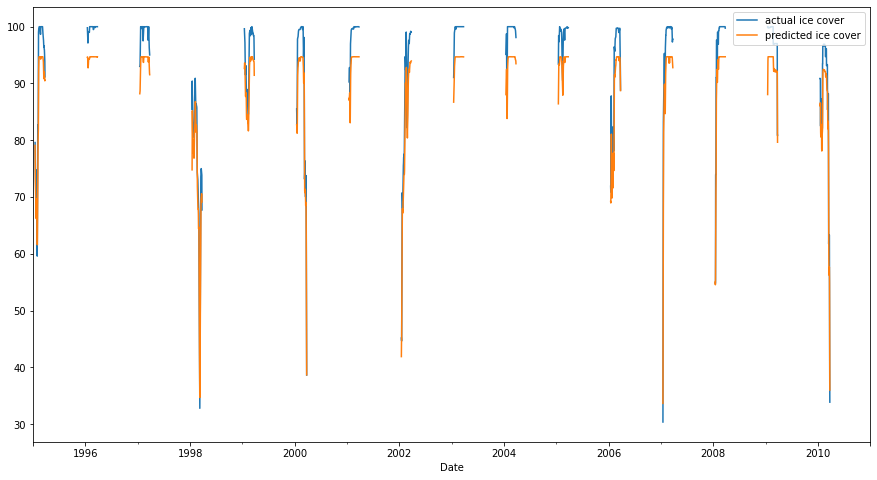

In [ ]:
# Overlaying the training predictions on top of training data
plt.figure(figsize=(15,8))

y_train = y_train.set_index('Date')
y_train_pred = y_train_pred.set_index('Date')
y_train['Ice'].plot(label = 'actual ice cover')
y_train_pred['Ice'].plot(label = 'predicted ice cover')
plt.legend(loc="upper right")

In [ ]:
df_var_imp['importance']

feature
Ice1            0.183053
Ice2            0.175696
Ice3            0.156286
Huron1          0.084902
Huron           0.060283
Huron2          0.049948
PNA3            0.044001
PNA             0.030139
Huron3          0.019970
SOI             0.017961
PNA2            0.015423
PNA1            0.011906
SOI1            0.008819
v-wind          0.007485
v-wind1         0.007445
NAO1            0.007275
EPNP1           0.007192
temperature3    0.007188
EPNP            0.006859
pressure2       0.005519
SOI2            0.005117
u-wind1         0.004698
EPNP3           0.004582
temperature1    0.004414
Sup.            0.004362
EPNP2           0.004237
temperature2    0.004183
v-wind2         0.004099
Sup.2           0.003904
temperature     0.003897
NAO             0.003776
u-wind          0.003718
humidity2       0.003685
Sup.3           0.003605
u-wind3         0.003547
humidity3       0.003328
u-wind2         0.003252
pressure        0.003192
pressure3       0.003171
NAO2            0

In [ ]:
### XGBoost model to forecast the ice for the next 14 days. Here we select 2020-02-15 as the 
### test data set.

split_date = '2020-02-15'

df_stable_train = df_stable.loc[df_stable.index < split_date].copy()
df_stable_test = df_stable.loc[df_stable.index == split_date].copy()

df_stable_train = pd.DataFrame(df_stable_train[['Ice', 'Ice1', 'Ice2', 'Ice3', 
                                                'Huron', 'Huron1', 'Huron2', 'Huron3', 
                                                'Sup.', 'Sup.1', 'Sup.2', 'Sup.3', 
                                                'temperature', 'temperature1', 'temperature2', 'temperature3', 
                                                'pressure', 'SOI', 'humidity', 'PNA']])

df_stable_test = pd.DataFrame(df_stable_test[['Ice', 'Ice1', 'Ice2', 'Ice3', 
                                              'Huron', 'Huron1', 'Huron2', 'Huron3', 
                                              'Sup.', 'Sup.1', 'Sup.2', 'Sup.3', 
                                              'temperature', 'temperature1', 'temperature2', 'temperature3', 
                                              'pressure', 'SOI', 'humidity', 'PNA']])

X_train = df_stable_train.drop(['Ice'], axis = 1)
X_test = df_stable_test.drop(['Ice'], axis = 1)
y_train = df_stable_train['Ice']
y_test = df_stable_test['Ice']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

xgb1 = xgb.XGBRegressor()

parameters = {'objective' : ['reg:squarederror'],
              #'objective':['reg:tweedie'],
              'booster': ['gbtree'],
              'early_stopping_rounds' : [20],
              'learning_rate': [0.001],
              'max_depth': [3],
              'subsample': [0.6, 0.7, 0.8],
              'colsample_bytree': [0.6, 0.7, 0.8],
              'n_estimators': [3000],
              'eval_metric' : ['rmse'],
              'eval_set' : [[X_test, y_test]]}

tscv = TimeSeriesSplit(n_splits=10)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

(1787, 19) (1787,)
(1, 19) (1,)
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.9min finished


-5.411751577591982
{'booster': 'gbtree', 'colsample_bytree': 0.7, 'early_stopping_rounds': 20, 'eval_metric': 'rmse', 'eval_set': [                 Ice1       Ice2      Ice3     Huron    Huron1    Huron2  \
Date                                                                       
2020-02-15  98.201499  98.079835  98.40454  0.051862  0.053191  0.059397   

              Huron3      Sup.     Sup.1     Sup.2     Sup.3  temperature  \
Date                                                                        
2020-02-15  0.061613  0.058267  0.060757  0.066235  0.069721     0.352917   

            temperature1  temperature2  temperature3  pressure  SOI  humidity  \
Date                                                                            
2020-02-15      0.252926      0.244893      0.413763  0.576897  0.5  0.326957   

                 PNA  
Date                  
2020-02-15  0.542035  , Date
2020-02-15    98.539041
Name: Ice, dtype: float64], 'learning_rate': 0.001, 'max_depth': 

In [ ]:
### Predict ice cover on the day of the test data

y_test_pred = xgb_grid.predict(X_test)

y_test_pred

array([93.21672], dtype=float32)

In [ ]:
### Actual ice cover on the day of the test data

y_test

Date
2020-02-15    98.539041
Name: Ice, dtype: float64

In [ ]:
## calculating the mean absolute error

print(mean_absolute_error(y_test, y_test_pred))

5.322320804080448


In [ ]:
X_test.columns

Index(['Ice1', 'Ice2', 'Ice3', 'Huron', 'Huron1', 'Huron2', 'Huron3', 'Sup.',
       'Sup.1', 'Sup.2', 'Sup.3', 'temperature', 'temperature1',
       'temperature2', 'temperature3', 'pressure', 'SOI', 'humidity', 'PNA'],
      dtype='object')

In [ ]:
######### Using the predicted value on any date as ground truth and then forecast for next 14 days #################

from datetime import datetime, timedelta

X_train = X_train.reset_index()
X_train['month'] = X_train['Date'].dt.month
X_train['day'] = X_train['Date'].dt.day
X_train = X_train.set_index('Date')

for i in range(1, 15):

  res = (datetime.strptime(split_date, '%Y-%m-%d') + timedelta(days=i)).strftime('%Y-%m-%d')
    
  df_data_test = df_stable.loc[df_stable.index == res].copy()

  df_test = X_train[(X_train['month'] == df_data_test.index.month.values[0]) & (X_train['day'] == df_data_test.index.day.values[0])]
  df_test = df_test.dropna()

  X_test['Ice3'] = X_test['Ice2']
  X_test['Ice2'] = X_test['Ice1']
  X_test['Ice1'] = y_test_pred
  
  X_test['Sup.3'] = df_test.groupby(['month', 'day'])['Sup.3'].mean().values
  X_test['Sup.2'] = df_test.groupby(['month', 'day'])['Sup.2'].mean().values
  X_test['Sup.1'] = df_test.groupby(['month', 'day'])['Sup.1'].mean().values
  X_test['Sup.'] = df_test.groupby(['month', 'day'])['Sup.'].mean().values
  
  X_test['Huron3'] = df_test.groupby(['month', 'day'])['Huron3'].mean().values
  X_test['Huron2'] = df_test.groupby(['month', 'day'])['Huron2'].mean().values
  X_test['Huron1'] = df_test.groupby(['month', 'day'])['Huron1'].mean().values
  X_test['Huron'] = df_test.groupby(['month', 'day'])['Huron'].mean().values

  X_test['temperature3'] = df_test.groupby(['month', 'day'])['temperature3'].mean().values
  X_test['temperature2'] = df_test.groupby(['month', 'day'])['temperature2'].mean().values
  X_test['temperature1'] = df_test.groupby(['month', 'day'])['temperature1'].mean().values
  X_test['temperature'] = df_test.groupby(['month', 'day'])['temperature'].mean().values

  X_test['pressure'] = df_test.groupby(['month', 'day'])['pressure'].mean().values
  X_test['PNA'] = df_test.groupby(['month', 'day'])['PNA'].mean().values
  X_test['SOI'] = df_test.groupby(['month', 'day'])['SOI'].mean().values
  X_test['humidity'] = df_test.groupby(['month', 'day'])['humidity'].mean().values
    
  y_test = df_data_test['Ice']
  
  y_test_pred = xgb_grid.predict(X_test)
    
  print(res, y_test, y_test_pred)

2020-02-16 Date
2020-02-16    98.633742
Name: Ice, dtype: float64 [89.79995]
2020-02-17 Date
2020-02-17    99.025971
Name: Ice, dtype: float64 [86.314545]
2020-02-18 Date
2020-02-18    98.215087
Name: Ice, dtype: float64 [83.91312]
2020-02-19 Date
2020-02-19    98.025897
Name: Ice, dtype: float64 [81.20702]
2020-02-20 Date
2020-02-20    99.566163
Name: Ice, dtype: float64 [76.956184]
2020-02-21 Date
2020-02-21    99.444616
Name: Ice, dtype: float64 [74.068535]
2020-02-22 Date
2020-02-22    99.417589
Name: Ice, dtype: float64 [71.187454]
2020-02-23 Date
2020-02-23    99.457865
Name: Ice, dtype: float64 [68.70909]
2020-02-24 Date
2020-02-24    99.728273
Name: Ice, dtype: float64 [67.504486]
2020-02-25 Date
2020-02-25    99.728273
Name: Ice, dtype: float64 [66.95795]
2020-02-26 Date
2020-02-26    99.863408
Name: Ice, dtype: float64 [67.048096]
2020-02-27 Date
2020-02-27    99.647181
Name: Ice, dtype: float64 [66.958824]
2020-02-28 Date
2020-02-28    99.782327
Name: Ice, dtype: float64 [66

### Modeling for Melting Period

In [ ]:
# Separating the Independent and dependent variables

X = df_melting.drop(['Ice'], axis = 1)
y = df_melting['Ice']

X = X.drop(['year', 'month', 'day'], axis = 1)

In [ ]:
########## Melting Phase: Mar 26 - May 10

X_train = X['1995-03-26':'2010-05-10']
X_valid = X['2011-03-26':'2015-05-10']
y_train = y['1995-03-26':'2010-05-10']
y_valid = y['2011-03-26':'2015-05-10']
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(736, 47) (736,)
(230, 47) (230,)


In [ ]:
X_test = X['2016-03-26':'2021-05-10']
y_test = y['2016-03-26':'2021-05-10']
print(X_valid.shape, y_valid.shape)

(230, 47) (230,)


In [ ]:
# Running the XGBoost regressor with a wide range of hyper parameters and 10 CV timeseries splits

t0 = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'objective' : ['reg:squarederror'],
              #'objective':['reg:tweedie'],
              'booster': ['gbtree'],
              'early_stopping_rounds' : [20],
              'learning_rate': [0.001],
              'max_depth': [3],
              'subsample': [0.7, 0.8],
              'colsample_bytree': [0.5, 0.6],
              'n_estimators': [2500],
              'eval_metric' : ['rmse'],
              'eval_set' : [[X_valid, y_valid]]}

tscv = TimeSeriesSplit(n_splits=10)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=False)

xgb_grid.fit(X_train, y_train)

tF = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

print('Time to train = %.2f seconds' % (tF - t0))

0.9453723520153223
{'booster': 'gbtree', 'colsample_bytree': 0.6, 'early_stopping_rounds': 20, 'eval_metric': 'rmse', 'eval_set': [                 Ice1       Ice2       Ice3    u-wind    v-wind  pressure  \
Date                                                                        
2011-03-26  96.079592  95.944468  96.214738  0.504081  0.345191  0.667292   
2011-03-27  96.079592  96.079592  95.944468  0.539967  0.361651  0.676940   
2011-03-28  94.944489  96.079592  96.079592  0.590191  0.386034  0.658541   
2011-03-29  96.268782  94.944489  96.079592  0.579435  0.407994  0.681160   
2011-03-30  96.376869  96.268782  94.944489  0.504885  0.441435  0.641861   
2011-03-31  93.647783  96.376869  96.268782  0.551893  0.409185  0.525489   
2011-04-01  94.066776  93.647783  96.376869  0.575951  0.478084  0.308723   
2011-04-02  92.484481  94.066776  93.647783  0.621023  0.402102  0.287824   
2011-04-03  92.511518  92.484481  94.066776  0.505957  0.520784  0.440915   
2011-04-04  93.916934 

In [ ]:
# Predicting on the training data and calculating the mean absolute error

y_train_pred = xgb_grid.predict(X_train)

print(mean_absolute_error(y_train, y_train_pred))
print(math.sqrt(mean_squared_error(y_train, y_train_pred)))

3.843489201391634
5.493084615910954


In [ ]:
# Predicting on the validation data and calculating the mean absolute error

y_valid_pred = xgb_grid.predict(X_valid)

print(mean_absolute_error(y_valid, y_valid_pred))
print(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

6.667697689846315
10.128414099642486


In [ ]:
# Predicting on the testation data and calculating the mean absolute error

y_test_pred = xgb_grid.predict(X_test)
y_test_pred[y_test_pred < 0] = 0

print(mean_absolute_error(y_test, y_test_pred))
print(math.sqrt(mean_squared_error(y_test, y_test_pred)))

4.811369536099157
7.317342771495018


In [ ]:
df_train = X_train.copy()
df_train['y_train'] = y_train
df_train['y_train_pred'] = y_train_pred

df_valid = X_valid.copy()
df_valid['y_valid'] = y_valid
df_valid['y_valid_pred'] = y_valid_pred

df_test = X_test.copy()
df_test['y_test'] = y_test
df_test['y_test_pred'] = y_test_pred

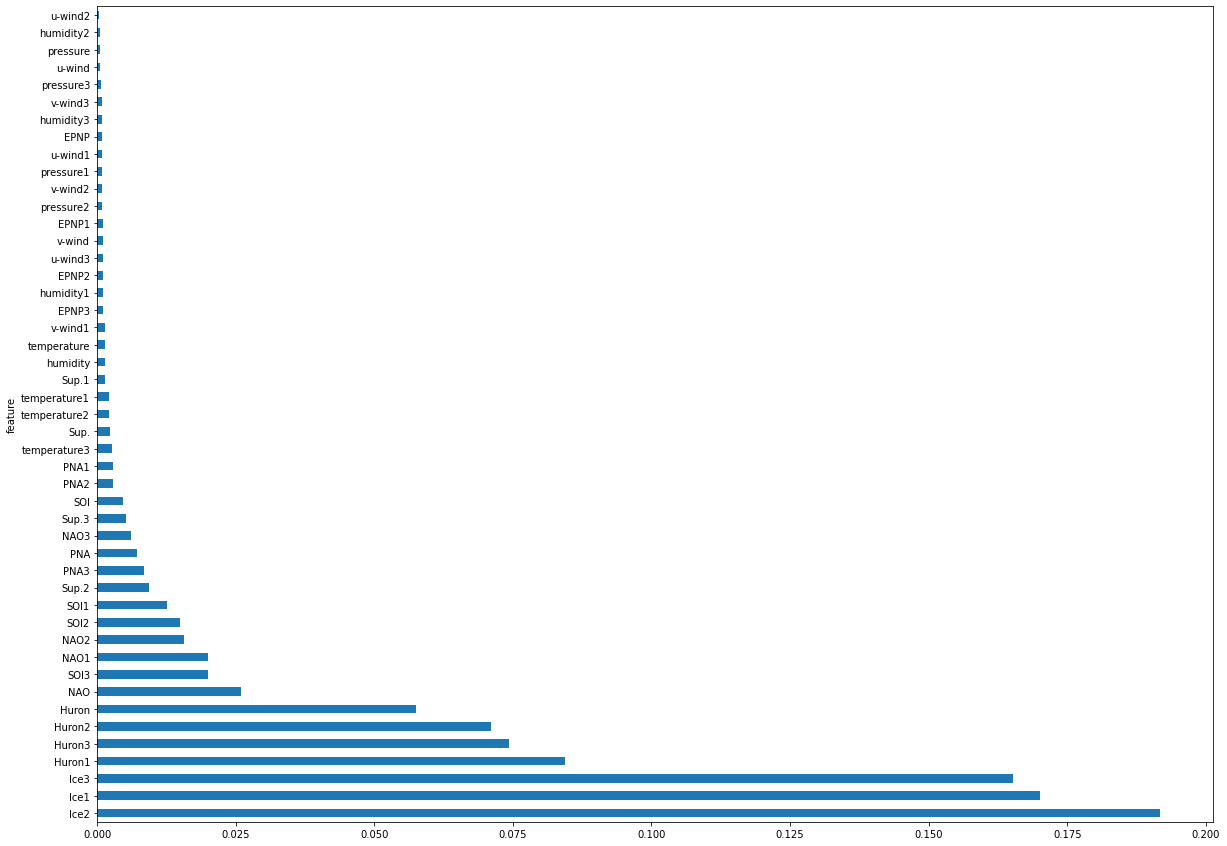

In [ ]:
# Calculating variable importance as per the XGBoost model.

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_valid.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

# Displaying the variable importance

%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
df_var_imp['importance'].plot(kind = 'barh')

In [ ]:
y_train.tail()

Date
2010-05-06    0.0
2010-05-07    0.0
2010-05-08    0.0
2010-05-09    0.0
2010-05-10    0.0
Name: Ice, dtype: float64

In [ ]:
y_train = pd.DataFrame(y_train)
y_train = y_train.reset_index()
y_train.columns = ['Date', 'Ice']

y_train_pred = pd.DataFrame(y_train_pred)
y_train_pred['Date'] = y_train['Date']
y_train_pred.columns = ['Ice', 'Date']

from datetime import datetime
df_date = pd.DataFrame(pd.date_range(start="1995-01-01",end="2010-12-31"))
df_date.columns = ['Date']

y_train = pd.merge(df_date, y_train, on = 'Date', how = 'outer')

y_train_pred = pd.merge(df_date, y_train_pred, on = 'Date', how = 'outer')
y_train_pred

Date        Ice
0    1995-01-01        NaN
1    1995-01-02        NaN
2    1995-01-03        NaN
3    1995-01-04        NaN
4    1995-01-05        NaN
5    1995-01-06        NaN
6    1995-01-07        NaN
7    1995-01-08        NaN
8    1995-01-09        NaN
9    1995-01-10        NaN
10   1995-01-11        NaN
11   1995-01-12        NaN
12   1995-01-13        NaN
13   1995-01-14        NaN
14   1995-01-15        NaN
15   1995-01-16        NaN
16   1995-01-17        NaN
17   1995-01-18        NaN
18   1995-01-19        NaN
19   1995-01-20        NaN
20   1995-01-21        NaN
21   1995-01-22        NaN
22   1995-01-23        NaN
23   1995-01-24        NaN
24   1995-01-25        NaN
25   1995-01-26        NaN
26   1995-01-27        NaN
27   1995-01-28        NaN
28   1995-01-29        NaN
29   1995-01-30        NaN
30   1995-01-31        NaN
31   1995-02-01        NaN
32   1995-02-02        NaN
33   1995-02-03        NaN
34   1995-02-04        NaN
35   1995-02-05        NaN
36   1995-02-06        NaN
37   1995-02-07        NaN
38   1995-02-08        NaN
39   1995-02-09        NaN
40   1995-02-10        NaN
41   1995-02-11        NaN
42   1995-02-12        NaN
43   1995-02-13        NaN
44   1995-02-14        NaN
45   1995-02-15        NaN
46   1995-02-16        NaN
47   1995-02-17        NaN
48   1995-02-18        NaN
49   1995-02-19        NaN
50   1995-02-20        NaN
51   1995-02-21        NaN
52   1995-02-22        NaN
53   1995-02-23        NaN
54   1995-02-24        NaN
55   1995-02-25        NaN
56   1995-02-26        NaN
57   1995-02-27        NaN
58   1995-02-28        NaN
59   1995-03-01        NaN
60   1995-03-02        NaN
61   1995-03-03        NaN
62   1995-03-04        NaN
63   1995-03-05        NaN
64   1995-03-06        NaN
65   1995-03-07        NaN
66   1995-03-08        NaN
67   1995-03-09        NaN
68   1995-03-10        NaN
69   1995-03-11        NaN
70   1995-03-12        NaN
71   1995-03-13        NaN
72   1995-03-14        NaN
73   1995-03-15        NaN
74   1995-03-16        NaN
75   1995-03-17        NaN
76   1995-03-18        NaN
77   1995-03-19        NaN
78   1995-03-20        NaN
79   1995-03-21        NaN
80   1995-03-22        NaN
81   1995-03-23        NaN
82   1995-03-24        NaN
83   1995-03-25        NaN
84   1995-03-26  83.733078
85   1995-03-27  80.870987
86   1995-03-28  76.540268
87   1995-03-29  72.090141
88   1995-03-30  67.907326
89   1995-03-31  66.329262
90   1995-04-01  65.453903
91   1995-04-02  63.919640
92   1995-04-03  61.931919
93   1995-04-04  56.393902
94   1995-04-05  46.164455
95   1995-04-06  37.490528
96   1995-04-07  36.965981
97   1995-04-08  39.319363
98   1995-04-09  38.738674
99   1995-04-10  37.334938
100  1995-04-11  34.732029
101  1995-04-12  33.490299
102  1995-04-13  31.658659
103  1995-04-14  31.311041
104  1995-04-15  31.080097
105  1995-04-16  27.688448
106  1995-04-17  23.399000
107  1995-04-18  20.687489
108  1995-04-19  17.086884
109  1995-04-20  13.202873
110  1995-04-21   8.578316
111  1995-04-22   5.159237
112  1995-04-23   2.517718
113  1995-04-24   1.076551
114  1995-04-25   0.999230
115  1995-04-26   0.988922
116  1995-04-27   0.988922
117  1995-04-28   0.980871
118  1995-04-29   0.942309
119  1995-04-30   0.883127
120  1995-05-01   0.797061
121  1995-05-02   0.636470
122  1995-05-03   0.601177
123  1995-05-04   0.275371
124  1995-05-05   0.125418
125  1995-05-06   0.105150
126  1995-05-07   0.101715
127  1995-05-08   0.108342
128  1995-05-09   0.109302
129  1995-05-10   0.102270
130  1995-05-11        NaN
131  1995-05-12        NaN
132  1995-05-13        NaN
133  1995-05-14        NaN
134  1995-05-15        NaN
135  1995-05-16        NaN
136  1995-05-17        NaN
137  1995-05-18        NaN
138  1995-05-19        NaN
139  1995-05-20        NaN
140  1995-05-21        NaN
141  1995-05-22        NaN
142  1995-05-23        NaN
143  1995-05-24        NaN
144  1995-05-25        NaN
145  1995-05-26        NaN
146  1995-05-27        NaN
147  1995-05-28

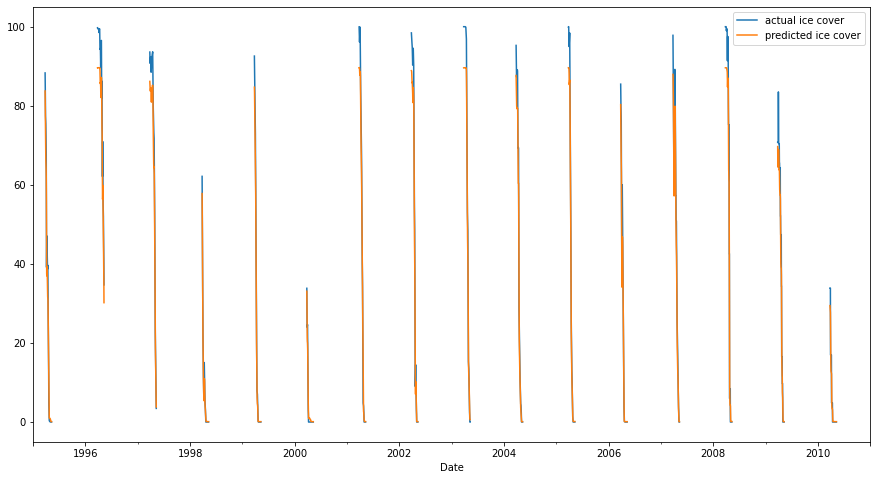

In [ ]:
# Overlaying the training predictions on top of training data
plt.figure(figsize=(15,8))

y_train = y_train.set_index('Date')
y_train_pred = y_train_pred.set_index('Date')
y_train['Ice'].plot(label = 'actual ice cover')
y_train_pred['Ice'].plot(label = 'predicted ice cover')
plt.legend(loc="upper right")

In [ ]:
df_var_imp['importance']

feature
Ice2            0.191729
Ice1            0.170089
Ice3            0.165138
Huron1          0.084369
Huron3          0.074336
Huron2          0.071013
Huron           0.057607
NAO             0.025928
SOI3            0.020094
NAO1            0.020036
NAO2            0.015676
SOI2            0.014946
SOI1            0.012561
Sup.2           0.009355
PNA3            0.008415
PNA             0.007120
NAO3            0.006171
Sup.3           0.005240
SOI             0.004728
PNA2            0.002887
PNA1            0.002819
temperature3    0.002665
Sup.            0.002323
temperature2    0.002109
temperature1    0.002103
Sup.1           0.001506
humidity        0.001473
temperature     0.001406
v-wind1         0.001364
EPNP3           0.001078
humidity1       0.001060
EPNP2           0.001034
u-wind3         0.000986
v-wind          0.000983
EPNP1           0.000980
pressure2       0.000962
v-wind2         0.000924
pressure1       0.000886
u-wind1         0.000877
EPNP            0

In [ ]:
### XGBoost model to forecast the ice for the next 14 days. Here we select 2020-04-15 as the 
### test data set.

split_date = '2020-04-15'

df_melting_train = df_melting.loc[df_melting.index < split_date].copy()
df_melting_test = df_melting.loc[df_melting.index == split_date].copy()

df_melting_train = pd.DataFrame(df_melting_train[['Ice', 'Ice1', 'Ice2', 'Ice3', 
                                                  'Huron', 'Huron1', 'Huron2', 'Huron3', 
                                                  'Sup.', 'Sup.1', 'Sup.2', 'Sup.3', 
                                                  'temperature', 'temperature1', 'temperature2', 'temperature3', 
                                                  'pressure', 'SOI', 'humidity', 'PNA']])

df_melting_test = pd.DataFrame(df_melting_test[['Ice', 'Ice1', 'Ice2', 'Ice3', 
                                                'Huron', 'Huron1', 'Huron2', 'Huron3', 
                                                'Sup.', 'Sup.1', 'Sup.2', 'Sup.3', 
                                                'temperature', 'temperature1', 'temperature2', 'temperature3', 
                                                'pressure', 'SOI', 'humidity', 'PNA']])

X_train = df_melting_train.drop(['Ice'], axis = 1)
X_test = df_melting_test.drop(['Ice'], axis = 1)
y_train = df_melting_train['Ice']
y_test = df_melting_test['Ice']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

xgb1 = xgb.XGBRegressor()

parameters = {'objective' : ['reg:squarederror'],
              #'objective':['reg:tweedie'],
              'booster': ['gbtree'],
              'early_stopping_rounds' : [20],
              'learning_rate': [0.001],
              'max_depth': [3],
              'subsample': [0.6, 0.7, 0.8],
              'colsample_bytree': [0.6, 0.7, 0.8],
              'n_estimators': [3000],
              'eval_metric' : ['rmse'],
              'eval_set' : [[X_test, y_test]]}

tscv = TimeSeriesSplit(n_splits=10)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

(1170, 19) (1170,)
(1, 19) (1,)
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.1min finished


0.9649535383674733
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'early_stopping_rounds': 20, 'eval_metric': 'rmse', 'eval_set': [                 Ice1       Ice2      Ice3     Huron    Huron1    Huron2  \
Date                                                                       
2020-04-15  22.673506  27.160563  33.40388  0.106826  0.108599  0.108599   

              Huron3      Sup.     Sup.1     Sup.2     Sup.3  temperature  \
Date                                                                        
2020-04-15  0.106826  0.076195  0.076693  0.078187  0.078187     0.405735   

            temperature1  temperature2  temperature3  pressure   SOI  \
Date                                                                   
2020-04-15      0.429047      0.515901      0.507762  0.496855  0.55   

            humidity       PNA  
Date                            
2020-04-15  0.173913  0.243363  , Date
2020-04-15    22.673506
Name: Ice, dtype: float64], 'learning_rate': 0.001, 'max_depth

In [ ]:
### Predict ice cover on the day of the test data

y_test_pred = xgb_grid.predict(X_test)

y_test_pred

array([18.908045], dtype=float32)

In [ ]:
### Actual ice cover on the day of the test data

y_test

Date
2020-04-15    22.673506
Name: Ice, dtype: float64

In [ ]:
## calculating the mean absolute error

print(mean_absolute_error(y_test, y_test_pred))

3.765461308247332


In [ ]:
X_test.columns

Index(['Ice1', 'Ice2', 'Ice3', 'Huron', 'Huron1', 'Huron2', 'Huron3', 'Sup.',
       'Sup.1', 'Sup.2', 'Sup.3', 'temperature', 'temperature1',
       'temperature2', 'temperature3', 'pressure', 'SOI', 'humidity', 'PNA'],
      dtype='object')

In [ ]:
######### Using the predicted value on any date as ground truth and then forecast for next 14 days #################

from datetime import datetime, timedelta

X_train = X_train.reset_index()
X_train['month'] = X_train['Date'].dt.month
X_train['day'] = X_train['Date'].dt.day
X_train = X_train.set_index('Date')

for i in range(1, 15):

  res = (datetime.strptime(split_date, '%Y-%m-%d') + timedelta(days=i)).strftime('%Y-%m-%d')
    
  df_data_test = df_melting.loc[df_melting.index == res].copy()

  df_test = X_train[(X_train['month'] == df_data_test.index.month.values[0]) & (X_train['day'] == df_data_test.index.day.values[0])]
  df_test = df_test.dropna()

  X_test['Ice3'] = X_test['Ice2']
  X_test['Ice2'] = X_test['Ice1']
  X_test['Ice1'] = y_test_pred
  
  X_test['Sup.3'] = df_test.groupby(['month', 'day'])['Sup.3'].mean().values
  X_test['Sup.2'] = df_test.groupby(['month', 'day'])['Sup.2'].mean().values
  X_test['Sup.1'] = df_test.groupby(['month', 'day'])['Sup.1'].mean().values
  X_test['Sup.'] = df_test.groupby(['month', 'day'])['Sup.'].mean().values
  
  X_test['Huron3'] = df_test.groupby(['month', 'day'])['Huron3'].mean().values
  X_test['Huron2'] = df_test.groupby(['month', 'day'])['Huron2'].mean().values
  X_test['Huron1'] = df_test.groupby(['month', 'day'])['Huron1'].mean().values
  X_test['Huron'] = df_test.groupby(['month', 'day'])['Huron'].mean().values

  X_test['temperature3'] = df_test.groupby(['month', 'day'])['temperature3'].mean().values
  X_test['temperature2'] = df_test.groupby(['month', 'day'])['temperature2'].mean().values
  X_test['temperature1'] = df_test.groupby(['month', 'day'])['temperature1'].mean().values
  X_test['temperature'] = df_test.groupby(['month', 'day'])['temperature'].mean().values

  X_test['pressure'] = df_test.groupby(['month', 'day'])['pressure'].mean().values
  X_test['PNA'] = df_test.groupby(['month', 'day'])['PNA'].mean().values
  X_test['SOI'] = df_test.groupby(['month', 'day'])['SOI'].mean().values
  X_test['humidity'] = df_test.groupby(['month', 'day'])['humidity'].mean().values
    
  y_test = df_data_test['Ice']
  
  y_test_pred = xgb_grid.predict(X_test)
    
  print(res, y_test, y_test_pred)

2020-04-16 Date
2020-04-16    17.56478
Name: Ice, dtype: float64 [14.639111]
2020-04-17 Date
2020-04-17    15.24068
Name: Ice, dtype: float64 [10.881311]
2020-04-18 Date
2020-04-18    15.24068
Name: Ice, dtype: float64 [8.003019]
2020-04-19 Date
2020-04-19    30.0793
Name: Ice, dtype: float64 [5.7234054]
2020-04-20 Date
2020-04-20    13.349108
Name: Ice, dtype: float64 [4.836709]
2020-04-21 Date
2020-04-21    13.835513
Name: Ice, dtype: float64 [3.7464285]
2020-04-22 Date
2020-04-22    0.0
Name: Ice, dtype: float64 [1.7425127]
2020-04-23 Date
2020-04-23    0.0
Name: Ice, dtype: float64 [0.5516647]
2020-04-24 Date
2020-04-24    0.0
Name: Ice, dtype: float64 [0.42491943]
2020-04-25 Date
2020-04-25    0.0
Name: Ice, dtype: float64 [0.42491943]
2020-04-26 Date
2020-04-26    0.0
Name: Ice, dtype: float64 [0.42276525]
2020-04-27 Date
2020-04-27    0.0
Name: Ice, dtype: float64 [0.42159224]
2020-04-28 Date
2020-04-28    0.0
Name: Ice, dtype: float64 [0.4193814]
2020-04-29 Date
2020-04-29    0

#### 3. XGBoost Model development - DTLM4

In [ ]:
######### Creating lags and moving averages for Ice cover (DTLM) and Air Temperature(ATMP) features ################

for i in range(1,6):
    col = 'ATMP_lag_' + str(i)
    df_merge[col] = df_merge['ATMP'].shift(i)

for i in range(1,6):
    col = 'Ice_lag_' + str(i)
    df_merge[col] = df_merge['DTLM'].shift(i)

for i in range(3,6):
    col = 'ATMP_RM_' + str(i)
    df_merge[col] = df_merge['ATMP'].rolling(i).mean()
    df_merge[col] = df_merge[col].shift(1)

for i in range(3,6):
    col = 'Ice_RM_' + str(i)
    df_merge[col] = df_merge['DTLM'].rolling(i).mean()
    df_merge[col] = df_merge[col].shift(1)

df_merge.head()

In [ ]:
df_merge.tail()

In [ ]:
df_merge['PRES'].describe()

In [ ]:
# For Pressure feature, creating z-score as an additional feature
cols = ['PRES']

for col in cols:
    col_zscore = col + '_zscore'
    df_merge[col_zscore] = (df_merge[col] - df_merge[col].mean())/df_merge[col].std(ddof=0)

df_merge.head()

In [ ]:
df_merge[['WSPD', 'GST', 'PRES', 'ATMP', 'DTLM', 'PRES_zscore']].head()

In [ ]:
df_merge_ice_on_off = df_merge[['WSPD', 'GST', 'PRES', 'ATMP', 'DTLM']]
df_merge_ice_on_off.head(10)

In [ ]:
df_merge_ice_on_off.tail()

In [ ]:
df_merge_ice_on_off['month'] = pd.DatetimeIndex(df_merge_ice_on_off.index).month
df_merge_ice_on_off['year'] = pd.DatetimeIndex(df_merge_ice_on_off.index).year
df_merge_ice_on_off['day'] = pd.DatetimeIndex(df_merge_ice_on_off.index).day

df_merge_ice_on_off['Ice_RM_3'] = df_merge_ice_on_off['DTLM'].rolling(3).mean()

df_ice_off = df_merge_ice_on_off[(df_merge_ice_on_off['month'] <= 7) & (df_merge_ice_on_off['month'] > 1)]
df_ice_on = df_merge_ice_on_off[(df_merge_ice_on_off['month'] > 7)]

df_ice_on['Ice_on_off'] = np.where(df_ice_on['Ice_RM_3'] >= 10, 'Ice_on_date', 'Normal')
df_ice_on = df_ice_on[df_ice_on['Ice_on_off'] != 'Normal']
df_ice_on = df_ice_on.drop_duplicates(subset=['year', 'Ice_on_off'], keep='first')

df_ice_off['Ice_on_off'] = np.where((df_ice_off['month'] > 3) & (df_ice_off['Ice_RM_3'] <= 10), 'Ice_off_date', 'Normal')
df_ice_off = df_ice_off[df_ice_off['Ice_on_off'] != 'Normal']
df_ice_off = df_ice_off.drop_duplicates(subset=['year', 'Ice_on_off'], keep='first')

df_merge_ice_on_off = pd.concat([df_ice_off, df_ice_on], axis = 0)
df_merge_ice_on_off = df_merge_ice_on_off.reset_index()
df_merge_ice_on_off = df_merge_ice_on_off.sort_values(by = 'index')
df_merge_ice_on_off = df_merge_ice_on_off.set_index('index')

df_merge_ice_on_off = df_merge_ice_on_off[df_merge_ice_on_off['Ice_on_off'] != 'Normal']

df_merge_ice_on_off

In [ ]:
df_ice = pd.concat(dataframes_ice, sort = False)
df_ice = df_ice.reset_index()
df_ice.head()

In [ ]:
df_ice.tail()

In [ ]:
# Importing packages for XGBoost and K-fold Gridsearch
# In Anacomnda command propmpt execute the command conda install -c anaconda py-xgboost
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [ ]:
df_merge.head()

In [ ]:
df_merge.tail()

In [ ]:
# Separating the Independent/predictor and dependent/response(Ice cover) variables

X = df_merge.drop(['DTLM'], axis = 1)
y = df_merge['DTLM']

# Creating training and validation data for model building

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
#print(X_train.shape, y_train.shape)
#print(X_test.shape, y_test.shape)

In [ ]:
y

In [ ]:
X_train = X['2007-01-01':'2015-12-31']
X_test = X['2016-01-01':'2019-12-31']
y_train = y['2007-01-01':'2015-12-31']
y_test = y['2016-01-01':'2019-12-31']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
X_valid = X['2020-01-01':'2020-12-31']
y_valid = y['2020-01-01':'2020-12-31']

In [ ]:
X_valid

In [ ]:
# Running the XGBoost regressor with a wide range of hyper parameters and 5 CV timeseries splits

t0 = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [0.001, 0.01, 0.05, 0.1],
              'max_depth': [3, 4, 5],
              'subsample': [0.7, 0.8],
              'colsample_bytree': [1.0],
              'n_estimators': [100, 200]}

tscv = TimeSeriesSplit(n_splits=5)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

tF = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

print('Time to train = %.2f seconds' % (tF - t0))

In [ ]:
# Predicting on the training data and calculating the mean absolute error

y_train_pred = xgb_grid.predict(X_train)

print(mean_absolute_error(y_train, y_train_pred))

In [ ]:
# Predicting on the test data and calculating the mean absolute error

y_test_pred = xgb_grid.predict(X_test)

print(mean_absolute_error(y_test, y_test_pred))

In [ ]:
# Predicting on the validation data and calculating the mean absolute error

y_valid_pred = xgb_grid.predict(X_valid)

print(mean_absolute_error(y_valid, y_valid_pred))

In [ ]:
df_train = X_train.copy()
df_train['y_train'] = y_train
df_train['y_train_pred'] = y_train_pred

df_test = X_test.copy()
df_test['y_test'] = y_test
df_test['y_test_pred'] = y_test_pred

df_valid = X_valid.copy()
df_valid['y_valid'] = y_valid
df_valid['y_valid_pred'] = y_valid_pred

In [ ]:
df_test = df_test[['WSPD', 'GST', 'PRES', 'ATMP', 'y_test', 'y_test_pred']]
df_valid = df_valid[['WSPD', 'GST', 'PRES', 'ATMP', 'y_valid', 'y_valid_pred']]
df_train = df_train[['WSPD', 'GST', 'PRES', 'ATMP', 'y_train', 'y_train_pred']]

df_test.columns = ['WSPD', 'GST', 'PRES', 'ATMP', 'DTLM', 'DTLM_Pred']
df_valid.columns = ['WSPD', 'GST', 'PRES', 'ATMP', 'DTLM', 'DTLM_Pred']
df_train.columns = ['WSPD', 'GST', 'PRES', 'ATMP', 'DTLM', 'DTLM_Pred']


df_test['DTLM_Pred_RM_3'] = df_test['DTLM_Pred'].rolling(3).mean()
#df_test['DTLM_Pred_RM_3'] = df_test['DTLM_Pred_RM_3'].shift(1)

df_valid['DTLM_Pred_RM_3'] = df_valid['DTLM_Pred'].rolling(3).mean()

df_train['DTLM_Pred_RM_3'] = df_train['DTLM_Pred'].rolling(3).mean()
#df_train['DTLM_Pred_RM_3'] = df_train['DTLM_Pred_RM_3'].shift(1)

df_ml = pd.concat([df_train, df_test, df_valid], axis = 0)
df_ml.head()

In [ ]:
df_ml.tail()

In [ ]:
df_ml['month'] = pd.DatetimeIndex(df_ml.index).month
df_ml['year'] = pd.DatetimeIndex(df_ml.index).year
df_ml['day'] = pd.DatetimeIndex(df_ml.index).day

df_ice_off = df_ml[(df_ml['month'] <= 7) & (df_ml['month'] > 1)]
df_ice_on = df_ml[(df_ml['month'] > 7)]

df_ice_on['Ice_on_off'] = np.where(df_ice_on['DTLM_Pred_RM_3'] >= 10, 'Ice_on_date', 'Normal')
df_ice_on = df_ice_on[df_ice_on['Ice_on_off'] != 'Normal']
df_ice_on = df_ice_on.drop_duplicates(subset=['year', 'Ice_on_off'], keep='first')

df_ice_off['Ice_on_off'] = np.where((df_ice_off['month'] > 3) & (df_ice_off['DTLM_Pred_RM_3'] <= 10), 'Ice_off_date', 'Normal')
df_ice_off = df_ice_off[df_ice_off['Ice_on_off'] != 'Normal']
df_ice_off = df_ice_off.drop_duplicates(subset=['year', 'Ice_on_off'], keep='first')

df_ml = pd.concat([df_ice_off, df_ice_on], axis = 0)
df_ml = df_ml.reset_index()
df_ml = df_ml.sort_values(by = 'index')
df_ml = df_ml.set_index('index')

df_ml

In [ ]:
df_ice_off

In [ ]:
##################### Creating actual Ice duration dataframe #######################

df_merge_ice_on_off = df_merge_ice_on_off.reset_index()
df_merge_ice_on_off.rename(columns={'index':'Date'}, inplace = True)

df_ice_on = df_merge_ice_on_off[df_merge_ice_on_off['Ice_on_off'] == 'Ice_on_date']
df_ice_off = df_merge_ice_on_off[df_merge_ice_on_off['Ice_on_off'] == 'Ice_off_date']

df_ice_on.rename(columns={'Date':'Ice_on_date'}, inplace = True)
df_ice_off.rename(columns={'Date':'Ice_off_date'}, inplace = True)

df_ice_on = df_ice_on[['year', 'Ice_on_date']]
df_ice_off = df_ice_off[['year', 'Ice_off_date']]

df2 = {'year': 2015, 'Ice_on_date': '2015-12-15'}
df_ice_on = df_ice_on.append(df2, ignore_index = True)
df_ice_on['Ice_on_date'] = pd.to_datetime(df_ice_on['Ice_on_date'])
df_ice_on = df_ice_on.sort_values(by = ['year'])

df_actual_ice = df_ice_off.merge(df_ice_on, on = 'year', how = 'left')
df_actual_ice['Ice_off_date'] = pd.to_datetime(df_actual_ice['Ice_off_date'])
df_actual_ice['Ice_on_date'] = pd.to_datetime(df_actual_ice['Ice_on_date'])
df_actual_ice['duration'] = df_actual_ice['Ice_off_date'].shift(-1) - df_actual_ice['Ice_on_date']

##################### Creating predicted Ice duration dataframe #######################

df_ml = df_ml.reset_index()
df_ml.rename(columns={'index':'Date'}, inplace = True)

df_ice_on = df_ml[df_ml['Ice_on_off'] == 'Ice_on_date']
df_ice_off = df_ml[df_ml['Ice_on_off'] == 'Ice_off_date']

df_ice_on.rename(columns={'Date':'Ice_on_date'}, inplace = True)
df_ice_off.rename(columns={'Date':'Ice_off_date'}, inplace = True)

df_ice_on = df_ice_on[['year', 'Ice_on_date']]
df_ice_off = df_ice_off[['year', 'Ice_off_date']]

df2 = {'year': 2015, 'Ice_on_date': '2015-12-15'}
df_ice_on = df_ice_on.append(df2, ignore_index = True)
df_ice_on['Ice_on_date'] = pd.to_datetime(df_ice_on['Ice_on_date'])
df_ice_on = df_ice_on.sort_values(by = ['year'])

df_predicted_ice = df_ice_off.merge(df_ice_on, on = 'year', how = 'left')
df_predicted_ice['Ice_off_date'] = pd.to_datetime(df_predicted_ice['Ice_off_date'])
df_predicted_ice['Ice_on_date'] = pd.to_datetime(df_predicted_ice['Ice_on_date'])
df_predicted_ice['duration'] = df_predicted_ice['Ice_off_date'].shift(-1) - df_predicted_ice['Ice_on_date']
df_predicted_ice

In [ ]:
#to use in final merged code later on
df_icedur_pred_dtlm4 = df_predicted_ice

In [ ]:
#to use in final merged code later on
df_icedur_act_dtlm4 = df_actual_ice

In [ ]:
# Draw the Ice-on and Ice-off plots


df_original = df_actual_ice
df = df_predicted_ice

xValue_original = []
yValue_original = []
xValue = []
yValue = []
tick_spacing = 5

for i in range(1,len(df_original['year'])):
    if(int(df_original['Ice_off_date'][i].strftime("%m")) < 11):
        xValue_original.append(df_original['year'][i])
        xValue_original.append(df_original['year'][i])
    else:
        xValue_original.append(df_original['year'][i]+1)
        xValue_original.append(df_original['year'][i]+1)

for i in range(1,len(df['year'])):
    if(int(df['Ice_off_date'][i].strftime("%m")) < 11):
        xValue.append(df['year'][i])
        xValue.append(df['year'][i])
    else:
        xValue.append(df['year'][i]+1)
        xValue.append(df['year'][i]+1)
        
    
for i in range(0,(len(df_original['Ice_off_date'])-1)):
    if(int(df_original['Ice_on_date'][i].strftime("%m")) >= 11):
        start_date = datetime(int(df_original['Ice_on_date'][i].strftime("%Y")),11,1,0,0,0)
    yValue_original.append((df_original['Ice_on_date'][i]-start_date).days)
    yValue_original.append((df_original['Ice_off_date'][i+1]-start_date).days)

for i in range(0,(len(df['Ice_off_date'])-1)):
    if(int(df['Ice_on_date'][i].strftime("%m")) >= 11):
        start_date = datetime(int(df['Ice_on_date'][i].strftime("%Y")),11,1,0,0,0)
    else:
        start_date = datetime(int(df['Ice_on_date'][i].strftime("%Y"))-1,11,1,0,0,0)
    yValue.append((df['Ice_on_date'][i]-start_date).days)
    yValue.append((df['Ice_off_date'][i+1]-start_date).days)


      
plt.figure(figsize=(16,8))  

for i in range(0, int(len(xValue)/2)):

    plt.annotate(df['Ice_on_date'][i].strftime("%Y-%m-%d"),(xValue[2*i],yValue[2*i]), xytext=(xValue[2*i]+0.25,yValue[2*i] -2), fontsize=8)
#     plt.annotate(df['Ice_off_date'][i+1].strftime("%Y-%m-%d"),(xValue[2*i+1],yValue[2*i+1]), xytext=(xValue[2*i+1]-0.8,yValue[2*i+1]), fontsize=8)

    

# for i in range(0, int(len(xValue_original)/2)):
#     ice_on_point = plt.scatter(xValue_original[2*i], yValue_original[2*i], color = 'r', s=6. )
#     ice_off_point = plt.scatter(xValue_original[2*i+1], yValue_original[2*i+1], color = 'b', s=6.)
    
# for i in range(0, int(len(xValue)/2)):
#     ice_on_point = plt.scatter(xValue[2*i] + 0.3, yValue[2*i], color = 'y', s=6. )
#     ice_off_point = plt.scatter(xValue[2*i+1] + 0.3, yValue[2*i+1], color = 'g', s=6.)


# l2 = plt.legend([ice_on_point, ice_off_point], labels = ['Ice On Date', 'Ice Off Date'], bbox_to_anchor=(1.05, 0), loc=1, borderaxespad=0)            


    
for i in range(0, int(len(xValue_original)/2)):
    if(i==0):
        line1 = plt.plot([xValue_original[2*i], xValue_original[2*i+1]],[yValue_original[2*i], yValue_original[2*i+1]],  color ='k', label = 'Original')
        
    line1 = plt.plot([xValue_original[2*i], xValue_original[2*i+1]],[yValue_original[2*i], yValue_original[2*i+1]],  color ='k')

plt.legend()
    #     plt.annotate(df['Ice Duration'][i], ((xValue[2*i]+xValue[2*i+1])/2, (yValue[2*i]+yValue[2*i+1])/2), ((xValue[2*i]+xValue[2*i+1])/2+0.1, (yValue[2*i]+yValue[2*i+1])/2))
    
for j in range(0, int(len(xValue)/2)):
    if(j == 0):
        line2 = plt.plot([xValue[2*j] + 0.3, xValue[2*j+1]+0.3],[yValue[2*j], yValue[2*j+1]], label = 'predicted', color = 'r')
        
    line2 = plt.plot([xValue[2*j] + 0.3, xValue[2*j+1]+0.3],[yValue[2*j], yValue[2*j+1]], color = 'r')  

plt.legend(loc='upper right', fontsize = 12)
        
    
# plt.legend([line1, line2], labels=['Original', 'Predicted'], bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0)


# plt.gca().add_artist(l2)




plt.title('Ice Season Duration Original vs Predicted for station DTLM4' , fontsize=20)

# plt.axis('off')
plt.yticks([])


frame = plt.gca().axes.get_xaxis().set_visible(False)

plt.savefig('ice_duration_DTLM4.png')

In [ ]:
#df_ml.to_csv('predicted_ice_on_off.csv', index = True)

In [ ]:
# Calculating variable importance as per the XGBoost model.

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_test.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

In [ ]:
# Displaying the variable importance

%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
df_var_imp['importance'].plot(kind = 'barh')

In [ ]:
print(df_var_imp)

In [ ]:
# Overlaying the training predictions on top of training data

plt.figure(figsize=(15,8))
df_train['DTLM'].plot(label = 'actual ice cover')
df_train['DTLM_Pred'].plot(label = 'predicted ice cover')
plt.legend(loc="upper right")

In [ ]:
########################## Code for Baseline vs Actual vs Predicted Ice cover #######################

df_plot = pd.concat([df_train, df_test, df_valid], axis = 0)
df_plot = df_plot.drop(['WSPD', 'GST', 'PRES', 'ATMP', 'DTLM_Pred_RM_3'], axis = 1)
df_plot['year'] = df_plot.index.year
df_plot['month'] = df_plot.index.month
df_plot['day'] = df_plot.index.day

df_plot_2020 = df_plot[df_plot['year'] == 2020]
df_plot_rem = df_plot[df_plot['year'] <= 2019]

res = pd.DataFrame(df_plot_rem.groupby(['month', 'day'])['DTLM'].mean().reset_index())
res = res.rename(columns = {'DTLM': 'DTLM_Baseline'})
df_plot_2020_final = df_plot_2020.merge(res, on = ['month', 'day'], how = 'inner')
df_plot_2020_final.index = df_plot_2020.index

df_plot_2019 = df_plot[df_plot['year'] == 2019]
df_plot_rem = df_plot[df_plot['year'] <= 2018]

res = pd.DataFrame(df_plot_rem.groupby(['month', 'day'])['DTLM'].mean().reset_index())
res = res.rename(columns = {'DTLM': 'DTLM_Baseline'})
df_plot_2019_final = df_plot_2019.merge(res, on = ['month', 'day'], how = 'inner')
df_plot_2019_final.index = df_plot_2019.index

df_plot_2018 = df_plot[df_plot['year'] == 2018]
df_plot_rem = df_plot[df_plot['year'] <= 2017]

res = pd.DataFrame(df_plot_rem.groupby(['month', 'day'])['DTLM'].mean().reset_index())
res = res.rename(columns = {'DTLM': 'DTLM_Baseline'})
df_plot_2018_final = df_plot_2018.merge(res, on = ['month', 'day'], how = 'inner')
df_plot_2018_final.index = df_plot_2018.index

df_plot_final = pd.concat([df_plot_2018_final, df_plot_2019_final, df_plot_2020_final], axis = 0)
df_plot_final

In [ ]:
# Overlaying the 2018 and 2019 predictions and baseline on top of actual data

plt.figure(figsize=(15,8))
df_subset_2020 = df_plot_final.loc['2018-01-01':'2020-12-31']
df_subset = df_plot_final.loc['2018-01-01':'2019-12-31']
df_subset['DTLM'].plot(label = 'actual ice cover')
df_subset['DTLM_Pred'].plot(label = 'predicted ice cover')
df_subset['DTLM_Baseline'].plot(label = 'baseline ice cover')
plt.legend(loc="lower left")

In [ ]:
df_dtlm4_2018_2019 = df_subset_2020

In [ ]:
# Overlaying the 2018 and 2019 predictions on top of actual data

plt.figure(figsize=(15,8))
df_subset = df_plot_final.loc['2018-01-01':'2019-12-31']
df_subset['DTLM'].plot(label = 'actual ice cover')
df_subset['DTLM_Pred'].plot(label = 'predicted ice cover')
plt.legend(loc="lower left")

In [ ]:
# Overlaying January 2019 predictions on top of actual data for January 2019

plt.figure(figsize=(15,8))
df_subset = df_test.loc['2019-01-01':'2019-01-31']
df_subset['DTLM'].plot(label = 'actual ice cover')
df_subset['DTLM_Pred'].plot(label = 'predicted ice cover')
plt.legend(loc="upper left")

In [ ]:
### XGBoost model to forecast the ice for the next 14 days. Here we select 2019-02-01 as the split date

split_date = '2019-02-01'

df_merge_1 = df_merge[['DTLM', 'Ice_lag_1', 'Ice_RM_3', 'Ice_RM_4', 'Ice_RM_5',  
                      'ATMP_RM_4', 'ATMP_RM_3', 'ATMP_RM_5', 'Ice_lag_2', 'ATMP_lag_4', 'ATMP', 'Ice_lag_3','Ice_lag_4', 'Ice_lag_5']]

df_merge_train = df_merge_1.loc[df_merge.index < split_date].copy()
df_merge_test = df_merge_1.loc[df_merge.index == split_date].copy()

X_train = df_merge_train.drop(['DTLM'], axis = 1)
X_test = df_merge_test.drop(['DTLM'], axis = 1)
y_train = df_merge_train['DTLM']
y_test = df_merge_test['DTLM']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

xgb1 = xgb.XGBRegressor()
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [0.001, 0.01, 0.05, 0.1],
              'max_depth': [3],
              'subsample': [0.7, 0.8],
              'colsample_bytree': [1.0],
              'n_estimators': [100, 200]}

tscv = TimeSeriesSplit(n_splits=5)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

In [ ]:
### Predict ice cover on the day of the test data

y_test_pred = xgb_grid.predict(X_test)

y_test_pred

In [ ]:
### Actual ice cover on the day of the test data

y_test

In [ ]:
## calculating the mean absolute error

print(mean_absolute_error(y_test, y_test_pred))

In [ ]:
X_test.columns

In [ ]:
######### Using the predicted value on any date as ground truth and forecasting for next 14 days #################

for i in range(1, 15):
    X_test['Ice_lag_5'] = X_test['Ice_lag_4']
    X_test['Ice_lag_4'] = X_test['Ice_lag_3']
    X_test['Ice_lag_3'] = X_test['Ice_lag_2']
    X_test['Ice_lag_2'] = X_test['Ice_lag_1']
    X_test['Ice_lag_1'] = y_test_pred
    
    X_test['Ice_RM_3'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3']])
    X_test['Ice_RM_4'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3'], X_test['Ice_lag_4']])
    X_test['Ice_RM_5'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3'], 
                              X_test['Ice_lag_4'], X_test['Ice_lag_5']])
    
    res = (datetime.strptime(split_date, '%Y-%m-%d') + timedelta(days=i)).strftime('%Y-%m-%d')
    
    df_merge_test = df_merge_1.loc[df_merge.index == res].copy()
    
    y_test = df_merge_test['DTLM']
    
    y_test_pred = xgb_grid.predict(X_test)
    
    print(res, y_test, y_test_pred)

In [ ]:
print(mean_absolute_error(y_test, y_test_pred))

In [ ]:
######### Using the predicted value on any date as ground truth and forecasting for next 7 days #################

for i in range(1, 8):
    X_test['Ice_lag_5'] = X_test['Ice_lag_4']
    X_test['Ice_lag_4'] = X_test['Ice_lag_3']
    X_test['Ice_lag_3'] = X_test['Ice_lag_2']
    X_test['Ice_lag_2'] = X_test['Ice_lag_1']
    X_test['Ice_lag_1'] = y_test_pred
    
    X_test['Ice_RM_3'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3']])
    X_test['Ice_RM_4'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3'], X_test['Ice_lag_4']])
    X_test['Ice_RM_5'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3'], 
                              X_test['Ice_lag_4'], X_test['Ice_lag_5']])
    
    res = (datetime.strptime(split_date, '%Y-%m-%d') + timedelta(days=i)).strftime('%Y-%m-%d')
    
    df_merge_test = df_merge_1.loc[df_merge.index == res].copy()
    
    y_test = df_merge_test['DTLM']
    
    y_test_pred = xgb_grid.predict(X_test)
    
    print(res, y_test, y_test_pred)

In [ ]:
df_merge['year'] = pd.DatetimeIndex(df_merge.index).year
df_merge['month'] = pd.DatetimeIndex(df_merge.index).month
df_merge['day'] = pd.DatetimeIndex(df_merge.index).day
df_merge.head()

In [ ]:
########## Freezing Phase: Nov 25 - Jan 30
########## Stable Phase: Jan 31 - Mar 25
########## Melting Phase: Mar 26 - May 30
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_freezing = df_merge[df_merge['month'].isin([11, 12, 1])]
df_freezing = df_freezing[~((df_freezing['month'] == 11) & (df_freezing['day'] < 1))]
df_freezing = df_freezing[~((df_freezing['month'] == 1) & (df_freezing['day'] > 14))]

In [ ]:
df_stable = df_merge[df_merge['month'].isin([1, 2, 3])]
df_stable = df_stable[~((df_stable['month'] == 1) & (df_stable['day'] < 15))]
df_stable = df_stable[~((df_stable['month'] == 3) & (df_stable['day'] > 25))]

In [ ]:
df_melting = df_merge[df_merge['month'].isin([3, 4, 5])]
df_melting = df_melting[~((df_melting['month'] == 3) & (df_melting['day'] < 26))]
df_melting = df_melting[~((df_melting['month'] == 5) & (df_melting['day'] > 10))]

In [ ]:
df_freezing.head()

#### Training XGBoost Model on freezing period DTLM4

In [ ]:
# Separating the Independent and dependent variables

X = df_freezing.drop(['DTLM'], axis = 1)
y = df_freezing['DTLM']

X = X.drop(['year', 'month', 'day'], axis = 1)

In [ ]:
########## Freezing Phase: Dec 01 – Jan 14
########## Stable Phase: Jan 15 – Apr 05
########## Melting Phase: Apr 06 – May 30
X_train = X['2007-11-01':'2015-01-14']
X_test = X['2016-11-01':'2020-01-14']
y_train = y['2007-11-01':'2015-01-14']
y_test = y['2016-11-01':'2020-01-14']
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
# Running the XGBoost regressor with a wide range of hyper parameters and 5 CV timeseries splits

t0 = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [0.001, 0.01, 0.05, 0.1],
              'max_depth': [3, 4],
              'subsample': [0.7, 0.8],
              'colsample_bytree': [1.0],
              'n_estimators': [100, 200]}

tscv = TimeSeriesSplit(n_splits=5)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

tF = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

print('Time to train = %.2f seconds' % (tF - t0))

In [ ]:
# Predicting on the training data and calculating the mean absolute error

y_train_pred = xgb_grid.predict(X_train)

print(mean_absolute_error(y_train, y_train_pred))

In [ ]:
# Predicting on the testation data and calculating the mean absolute error

y_test_pred = xgb_grid.predict(X_test)
y_test_pred[y_test_pred < 0] = 0

print(mean_absolute_error(y_test, y_test_pred))

In [ ]:
df_train = X_train.copy()
df_train['y_train'] = y_train
df_train['y_train_pred'] = y_train_pred

df_test = X_test.copy()
df_test['y_test'] = y_test
df_test['y_test_pred'] = y_test_pred

In [ ]:
# Calculating variable importance as per the XGBoost model.

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_test.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

In [ ]:
# Displaying the variable importance

#%matplotlib inline
#fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
#df_var_imp['importance'].plot(kind = 'barh')

In [ ]:
print(df_var_imp)

In [ ]:
y_train = pd.DataFrame(y_train)
y_train = y_train.reset_index()
y_train.columns = ['date', 'DTLM']

y_train_pred = pd.DataFrame(y_train_pred)
y_train_pred['date'] = y_train['date']
y_train_pred.columns = ['DTLM', 'date']

from datetime import datetime
df_date = pd.DataFrame(pd.date_range(start="2007-01-01",end="2015-12-31"))
df_date.columns = ['date']

y_train = pd.merge(df_date, y_train, on = 'date', how = 'outer')

y_train_pred = pd.merge(df_date, y_train_pred, on = 'date', how = 'outer')
y_train_pred

# Overlaying the training predictions on top of training data
plt.figure(figsize=(15,8))

y_train = y_train.set_index('date')
y_train_pred = y_train_pred.set_index('date')
y_train['DTLM'].plot(label = 'actual ice cover')
y_train_pred['DTLM'].plot(label = 'predicted ice cover')
plt.legend(loc="upper right")

In [ ]:
### XGBoost model to forecast the ice for the next 14 days. Here we select 2019-01-01 as the 
### test data set.

split_date = '2019-01-01'

df_freeze_1 = df_freezing[['DTLM', 'Ice_lag_1', 'Ice_RM_3', 'Ice_RM_4', 'Ice_RM_5', 
                           'ATMP_RM_4', 'ATMP_RM_3', 'ATMP_RM_5', 'Ice_lag_2', 'ATMP_lag_4', 
                           'ATMP', 'Ice_lag_3','Ice_lag_4', 'Ice_lag_5']]

df_freeze_train = df_freeze_1.loc[df_freezing.index < split_date].copy()
df_freeze_test = df_freeze_1.loc[df_freezing.index == split_date].copy()

X_train = df_freeze_train.drop(['DTLM'], axis = 1)
X_test = df_freeze_test.drop(['DTLM'], axis = 1)
y_train = df_freeze_train['DTLM']
y_test = df_freeze_test['DTLM']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

xgb1 = xgb.XGBRegressor()
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [0.001, 0.01, 0.05, 0.1],
              'max_depth': [3],
              'subsample': [0.7, 0.8],
              'colsample_bytree': [1.0],
              'n_estimators': [100, 200]}

tscv = TimeSeriesSplit(n_splits=5)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

In [ ]:
### Predict ice cover on the day of the test data

y_test_pred = xgb_grid.predict(X_test)

y_test_pred

In [ ]:
### Actual ice cover on the day of the test data

y_test

In [ ]:
## calculating the mean absolute error

print(mean_absolute_error(y_test, y_test_pred))

In [ ]:
X_test.columns

In [ ]:
######### Using the predicted value on any date as ground truth and forecasting for next 14 days #################

for i in range(1, 15):
    X_test['Ice_lag_5'] = X_test['Ice_lag_4']
    X_test['Ice_lag_4'] = X_test['Ice_lag_3']
    X_test['Ice_lag_3'] = X_test['Ice_lag_2']
    X_test['Ice_lag_2'] = X_test['Ice_lag_1']
    X_test['Ice_lag_1'] = y_test_pred
    
    X_test['Ice_RM_3'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3']])
    X_test['Ice_RM_4'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3'], X_test['Ice_lag_4']])
    X_test['Ice_RM_5'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3'], 
                              X_test['Ice_lag_4'], X_test['Ice_lag_5']])
    
    res = (datetime.strptime(split_date, '%Y-%m-%d') + timedelta(days=i)).strftime('%Y-%m-%d')
    
    df_freeze_test = df_freeze_1.loc[df_freeze_1.index == res].copy()
    
    y_test = df_freeze_test['DTLM']
    
    y_test_pred = xgb_grid.predict(X_test)
    
    print(res, y_test, y_test_pred)

#### Training XGBoost Model on stable period DTLM4

In [ ]:
# Separating the Independent and dependent variables

X = df_stable.drop(['DTLM'], axis = 1)
y = df_stable['DTLM']

X = X.drop(['year', 'month', 'day'], axis = 1)

In [ ]:
########## Freezing Phase: Nov 01 – Jan 14
########## Stable Phase: Jan 15 – Mar 25
########## Melting Phase: Mar 26 – May 10
X_train = X['2007-01-15':'2015-03-25']
X_test = X['2016-01-15':'2020-03-25']
y_train = y['2007-01-15':'2015-03-25']
y_test = y['2016-01-15':'2020-03-25']
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
# Running the XGBoost regressor with a wide range of hyper parameters and 5 CV timeseries splits

t0 = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [0.001, 0.01, 0.05, 0.1],
              'max_depth': [3, 4],
              'subsample': [0.7, 0.8],
              'colsample_bytree': [1.0, 0.8],
              'n_estimators': [100, 200]}

tscv = TimeSeriesSplit(n_splits=5)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

tF = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
print('Time to train = %.2f seconds' % (tF - t0))

In [ ]:
# Predicting on the training data and calculating the mean absolute error

y_train_pred = xgb_grid.predict(X_train)

print(mean_absolute_error(y_train, y_train_pred))

In [ ]:
# Predicting on the testation data and calculating the mean absolute error

y_test_pred = xgb_grid.predict(X_test)
y_test_pred[y_test_pred < 0] = 0

print(mean_absolute_error(y_test, y_test_pred))

In [ ]:
df_train = X_train.copy()
df_train['y_train'] = y_train
df_train['y_train_pred'] = y_train_pred

df_test = X_test.copy()
df_test['y_test'] = y_test
df_test['y_test_pred'] = y_test_pred

In [ ]:
# Calculating variable importance as per the XGBoost model.

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_test.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

In [ ]:
# Displaying the variable importance

#%matplotlib inline
#fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
#df_var_imp['importance'].plot(kind = 'barh')

In [ ]:
print(df_var_imp)

In [ ]:
y_train = pd.DataFrame(y_train)
y_train = y_train.reset_index()
y_train.columns = ['date', 'DTLM']

y_train_pred = pd.DataFrame(y_train_pred)
y_train_pred['date'] = y_train['date']
y_train_pred.columns = ['DTLM', 'date']

from datetime import datetime
df_date = pd.DataFrame(pd.date_range(start="2007-01-01",end="2015-12-31"))
df_date.columns = ['date']

y_train = pd.merge(df_date, y_train, on = 'date', how = 'outer')

y_train_pred = pd.merge(df_date, y_train_pred, on = 'date', how = 'outer')
y_train_pred

# Overlaying the training predictions on top of training data
plt.figure(figsize=(15,8))

y_train = y_train.set_index('date')
y_train_pred = y_train_pred.set_index('date')
y_train['DTLM'].plot(label = 'actual ice cover')
y_train_pred['DTLM'].plot(label = 'predicted ice cover')
plt.legend(loc="upper right")

In [ ]:
### XGBoost model to forecast the ice for the next 14 days. Here we select 2019-03-01 as the 
### test data set.

split_date = '2019-03-01'

df_stable_1 = df_stable[['DTLM', 'Ice_lag_1', 'Ice_RM_3', 'Ice_RM_4', 'Ice_RM_5', 
                         'ATMP_RM_4', 'ATMP_RM_3', 'ATMP_RM_5', 'Ice_lag_2', 'ATMP_lag_4', 
                         'ATMP', 'Ice_lag_3','Ice_lag_4', 'Ice_lag_5']]

df_stable_train = df_stable_1.loc[df_stable_1.index < split_date].copy()
df_stable_test = df_stable_1.loc[df_stable_1.index == split_date].copy()

X_train = df_stable_train.drop(['DTLM'], axis = 1)
X_test = df_stable_test.drop(['DTLM'], axis = 1)
y_train = df_stable_train['DTLM']
y_test = df_stable_test['DTLM']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

xgb1 = xgb.XGBRegressor()
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [0.001, 0.01, 0.05, 0.1],
              'max_depth': [3, 4],
              'subsample': [0.7, 0.8],
              'colsample_bytree': [1.0, 0.6],
              'n_estimators': [100, 200]}

tscv = TimeSeriesSplit(n_splits=5)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

In [ ]:
### Predict ice cover on the day of the testation data

y_test_pred = xgb_grid.predict(X_test)

y_test_pred

In [ ]:
### Actual ice cover on the day of the testation data

y_test

In [ ]:
## calculating the mean absolute error

print(mean_absolute_error(y_test, y_test_pred))

In [ ]:
X_test

In [ ]:
######### Using the predicted value on any date as ground truth and forecasting for next 14 days #################

for i in range(1, 15):
    X_test['Ice_lag_5'] = X_test['Ice_lag_4']
    X_test['Ice_lag_4'] = X_test['Ice_lag_3']
    X_test['Ice_lag_3'] = X_test['Ice_lag_2']
    X_test['Ice_lag_2'] = X_test['Ice_lag_1']
    X_test['Ice_lag_1'] = y_test_pred
    
    X_test['Ice_RM_3'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3']])
    X_test['Ice_RM_4'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3'], X_test['Ice_lag_4']])
    X_test['Ice_RM_5'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3'], 
                              X_test['Ice_lag_4'], X_test['Ice_lag_5']])
    
    res = (datetime.strptime(split_date, '%Y-%m-%d') + timedelta(days=i)).strftime('%Y-%m-%d')
    
    df_stable_test = df_stable_1.loc[df_stable_1.index == res].copy()
    
    y_test = df_stable_test['DTLM']
    
    y_test_pred = xgb_grid.predict(X_test)
    
    print(res, y_test, y_test_pred)

In [ ]:
y_test

#### Training XGBoost Model on melting period DTLM4

In [ ]:
# Separating the Independent and dependent variables

X = df_melting.drop(['DTLM'], axis = 1)
y = df_melting['DTLM']

X = X.drop(['year', 'month', 'day'], axis = 1)

In [ ]:
########## Freezing Phase: Nov 01 – Jan 14
########## Stable Phase: Jan 15 – Mar 25
########## Melting Phase: Mar 26 – May 10
X_train = X['2007-03-26':'2015-05-10']
X_test = X['2016-03-26':'2020-05-10']
y_train = y['2007-03-26':'2015-05-10']
y_test = y['2016-03-26':'2020-05-10']
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
# Running the XGBoost regressor with a wide range of hyper parameters and 5 CV timeseries splits

t0 = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [0.001, 0.01, 0.05, 0.1],
              'max_depth': [3, 4],
              'subsample': [0.7, 0.8],
              'colsample_bytree': [1.0, 0.8],
              'n_estimators': [100, 200]}

tscv = TimeSeriesSplit(n_splits=5)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

tF = time.time()

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
print('Time to train = %.2f seconds' % (tF - t0))

In [ ]:
# Predicting on the training data and calculating the mean absolute error

y_train_pred = xgb_grid.predict(X_train)

print(mean_absolute_error(y_train, y_train_pred))

In [ ]:
# Predicting on the testation data and calculating the mean absolute error

y_test_pred = xgb_grid.predict(X_test)
y_test_pred[y_test_pred < 0] = 0

print(mean_absolute_error(y_test, y_test_pred))

In [ ]:
df_train = X_train.copy()
df_train['y_train'] = y_train
df_train['y_train_pred'] = y_train_pred

df_test = X_test.copy()
df_test['y_test'] = y_test
df_test['y_test_pred'] = y_test_pred

In [ ]:
# Calculating variable importance as per the XGBoost model.

var_importance = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_)
features = pd.DataFrame(X_test.columns)
df_var_imp = pd.concat([features, var_importance], axis = 1)
df_var_imp.columns = ['feature', 'importance']
df_var_imp = df_var_imp.sort_values(by = ['importance'], ascending = False)
df_var_imp = df_var_imp.set_index(['feature'])

In [ ]:
# Displaying the variable importance

#%matplotlib inline
#fig, ax = plt.subplots(figsize=(20, 15))
#plt.figure(figsize=(10,10))
#df_var_imp['importance'].plot(kind = 'barh')

In [ ]:
print(df_var_imp)

In [ ]:
y_train = pd.DataFrame(y_train)
y_train = y_train.reset_index()
y_train.columns = ['date', 'DTLM']

y_train_pred = pd.DataFrame(y_train_pred)
y_train_pred['date'] = y_train['date']
y_train_pred.columns = ['DTLM', 'date']

from datetime import datetime
df_date = pd.DataFrame(pd.date_range(start="2007-01-01",end="2015-12-31"))
df_date.columns = ['date']

y_train = pd.merge(df_date, y_train, on = 'date', how = 'outer')

y_train_pred = pd.merge(df_date, y_train_pred, on = 'date', how = 'outer')
y_train_pred

# Overlaying the training predictions on top of training data
plt.figure(figsize=(15,8))

y_train = y_train.set_index('date')
y_train_pred = y_train_pred.set_index('date')
y_train['DTLM'].plot(label = 'actual ice cover')
y_train_pred['DTLM'].plot(label = 'predicted ice cover')
plt.legend(loc="upper right")

In [ ]:
### XGBoost model to forecast the ice for the next 14 days. Here we select 2019-04-20 as the test data set.

split_date = '2019-04-20'

df_melting_1 = df_melting[['DTLM', 'Ice_lag_1', 'Ice_RM_3', 'Ice_RM_4', 'Ice_RM_5', 
                           'ATMP_RM_4', 'ATMP_RM_3', 'ATMP_RM_5', 'Ice_lag_2', 'ATMP_lag_4', 
                           'ATMP', 'Ice_lag_3','Ice_lag_4', 'Ice_lag_5']]

df_melting_train = df_melting_1.loc[df_melting_1.index < split_date].copy()
df_melting_test = df_melting_1.loc[df_melting_1.index == split_date].copy()

X_train = df_melting_train.drop(['DTLM'], axis = 1)
X_test = df_melting_test.drop(['DTLM'], axis = 1)
y_train = df_melting_train['DTLM']
y_test = df_melting_test['DTLM']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

xgb1 = xgb.XGBRegressor()
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [0.001, 0.01, 0.05, 0.1],
              'max_depth': [3, 4],
              'subsample': [0.7, 0.8],
              'colsample_bytree': [1.0, 0.6],
              'n_estimators': [100, 200]}

tscv = TimeSeriesSplit(n_splits=5)

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        n_jobs = -1,
                        cv = tscv,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

In [ ]:
### Predict ice cover on the day of the testation data

y_test_pred = xgb_grid.predict(X_test)

y_test_pred

In [ ]:
### Actual ice cover on the day of the testation data

y_test

In [ ]:
## calculating the mean absolute error

print(mean_absolute_error(y_test, y_test_pred))

In [ ]:
X_test.columns

In [ ]:
######### Using the predicted value on any date as ground truth and forecasting for next 14 days #################

for i in range(1, 15):
    X_test['Ice_lag_5'] = X_test['Ice_lag_4']
    X_test['Ice_lag_4'] = X_test['Ice_lag_3']
    X_test['Ice_lag_3'] = X_test['Ice_lag_2']
    X_test['Ice_lag_2'] = X_test['Ice_lag_1']
    X_test['Ice_lag_1'] = y_test_pred
    
    X_test['Ice_RM_3'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3']])
    X_test['Ice_RM_4'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3'], X_test['Ice_lag_4']])
    X_test['Ice_RM_5'] = np.mean([X_test['Ice_lag_1'], X_test['Ice_lag_2'], X_test['Ice_lag_3'], 
                              X_test['Ice_lag_4'], X_test['Ice_lag_5']])
    
    res = (datetime.strptime(split_date, '%Y-%m-%d') + timedelta(days=i)).strftime('%Y-%m-%d')
    
    df_melting_test = df_melting_1.loc[df_melting_1.index == res].copy()
    
    y_test = df_melting_test['DTLM']
    
    y_test_pred = xgb_grid.predict(X_test)
    
    print(res, y_test, y_test_pred)

In [ ]:
df_dtlm4_2018_2019.head()

In [ ]:
df_dtlm4_2018_2019.tail()

In [ ]:
df_dtlm4_2018_2019 = df_dtlm4_2018_2019.drop(['year', 'month', 'day'], axis = 1)

In [ ]:
df_dtlm4_2018_2019.head()

In [ ]:
df_dtlm4_2018_2019.tail()

In [ ]:
df_dtlm4_2018_2019.to_csv(r'C:/Users/sdavedu/Desktop/XGBoost/DTLM4_2018_2019.csv', index = True, header=True)

In [ ]:
df_icedur_pred_dtlm4.head()

In [ ]:
df_icedur_pred_dtlm4 = df_icedur_pred_dtlm4.drop(['duration'],axis=1)

In [ ]:
df_icedur_pred_dtlm4.head()

In [ ]:
df_icedur_pred_dtlm4.to_csv(r'C:/Users/sdavedu/Desktop/XGBoost/DTLM4_icedur_pred.csv', index = False, header=True)

In [ ]:
df_icedur_act_dtlm4.head()

In [ ]:
df_icedur_act_dtlm4 = df_icedur_act_dtlm4.drop(['duration'],axis=1)

In [ ]:
df_icedur_act_dtlm4.head()

In [ ]:
df_icedur_act_dtlm4.tail()

In [ ]:
df_icedur_act_dtlm4.to_csv(r'C:/Users/sdavedu/Desktop/XGBoost/DTLM4_icedur_act.csv', index = False, header=True)